----
## Summary
In the last notebook, I have prepared under sampled and over sampled dataset to check the accuracy of the CNN+MLP (Mixed Dataset) model. But before I ran the the model to classify cancer, I need to add density into list of features, where `0: 'Not Dense', 1: 'Dense'` since 50% of the patient's dataset was missing density classification. This should improve model prediction based on article [American Cancer Society](https://www.cancer.org/cancer/breast-cancer/screening-tests-and-early-detection/mammograms/breast-density-and-your-mammogram-report.html) and [National Library of Medicine](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6113143/#CR11) describing density classification improves the model prediction for particularly **MLO** view of the breast. This notebook has been ran on **Google Colab** 

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    RocCurveDisplay,
    accuracy_score,
    auc,
    roc_curve
)

# For reproducibility
np.random.seed(42)
from scipy import sparse


In [93]:
# Set up base folder path 
base_path = '/content/drive/MyDrive/General Assembly/breast_cancer_project/'
# Set up which resolution of mammogram needs to be picked
image_folder = 'breast_imaging_300px'

In [ ]:
# Load preprocessed Train, Test, Val dataset to classify density of the breast
density_train = pd.read_csv('/content/drive/MyDrive/General Assembly/breast_cancer_project/model_data/density_train.csv')
density_test = pd.read_csv('/content/drive/MyDrive/General Assembly/breast_cancer_project/model_data/density_test.csv')
density_predict = pd.read_csv('/content/drive/MyDrive/General Assembly/breast_cancer_project/model_data/predict_density_df.csv')

In [ ]:
# Check dataset shapes
density_train.shape, density_test.shape, density_predict.shape

((20603, 13), (8830, 13), (25236, 13))

In [ ]:
# Check if columns align with what expected
density_train.head(1)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case
0,1,63286,268346882,R,CC,40.0,0,0,0,1,0,2.0,False


In [ ]:
# Convert Object column datatypes into integer representation for Train, Test, and Val
density_train['laterality'] = density_train['laterality'].map({'L': 0, 'R': 1})
density_train['view'] = density_train['view'].map({'CC': 0, 'MLO': 1})

density_test['laterality'] = density_test['laterality'].map({'L': 0, 'R': 1})
density_test['view'] = density_test['view'].map({'CC': 0, 'MLO': 1})

density_predict['laterality'] = density_predict['laterality'].map({'L': 0, 'R': 1})
density_predict['view'] = density_predict['view'].map({'CC': 0, 'MLO': 1})


In [ ]:
# Add new column image uri for Train, Test, and Val 
density_train['img_uri'] = ''
density_test['img_uri'] = ''
density_predict['img_uri'] = ''

In [ ]:
# Check if newly added column exists
density_train.head(1)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,difficult_negative_case,img_uri
0,1,63286,268346882,1,0.0,40.0,0,0,0,1,0,2.0,False,


In [91]:
# TEMP
def extract_patient_image_file_path(
    target_folder, df, base_path, 
    target_A, target_B, patient_col, 
    image_id_col, image_uri_col, is_test=False
    ):
  
    if not is_test:
      cancer_path = f'{target_folder}/{target_A}'
      no_cancer_path = f'{target_folder}/{target_B}'
    else:
      test_path = f'{target_folder}/{target_A}'

    count = 0
    for index in df.index.tolist():
      path = ""
      img_prefix = ""
      patient_id = df.loc[index, patient_col]

      if not is_test:
        if df.loc[index, target_A] == 0:
          img_prefix = target_B
          path = f"{base_path}{no_cancer_path}/{patient_id}"

        else:
          img_prefix = target_A
          path = f"{base_path}{cancer_path}/{patient_id}"
      else:
        img_prefix = target_A
        path = f"{base_path}{test_path}/{patient_id}"

      patient_img_id = df.loc[index, image_id_col]

      path = f"{path}/{img_prefix}_{patient_id}_{patient_img_id}.npz"

      if os.path.exists(path):
        df.loc[index, image_uri_col] = path
    

In [ ]:
# Extract image file path for each petient
extract_patient_image_file_path(
    image_folder, density_train, base_path, 
    'cancer', 'no_cancer', 'patient_id', 'image_id', 'img_uri')

extract_patient_image_file_path(
    image_folder, density_test, base_path, 
    'cancer', 'no_cancer', 'patient_id', 'image_id', 'img_uri')

extract_patient_image_file_path(
    image_folder, density_predict, base_path, 
    'cancer', 'no_cancer', 'patient_id', 'image_id', 'img_uri')


In [ ]:
# Remove missing images
density_train = density_train[density_train['img_uri'] != '']
density_test = density_test[density_test['img_uri'] != '']
density_predict = density_predict[density_predict['img_uri'] != '']

In [5]:
def convert_image_to_3_channel(org_img):
  # Initialize 3 channeled image template filled with 0
  img = np.zeros( ( np.array(org_img).shape[0], np.array(org_img).shape[1], 3 ) )
  
  # same value in each channel
  img[:,:,0] = org_img 
  img[:,:,1] = org_img
  img[:,:,2] = org_img

  return img

In [6]:
def construct_image_array(sparse_dir_list):
    # Init list for image data
    image_data = []

    # Loop through directory list passed where sparse matrix stored
    for sparse_path in sparse_dir_list:
        # Load sparse matrix file
        sparse_matrix = sparse.load_npz(sparse_path)
        # Convert mammogram into 3 channeled image
        three_channel_image = convert_image_to_3_channel(sparse_matrix.todense())
        # Append new 3 channeled list into image data list
        image_data.append(three_channel_image)

    # Convert image data list into numpy array
    image_data = np.array(image_data)
    # Return the result
    return image_data


In [7]:
def generate_model_chart(base_path, title, model_name, target, res):
  # Set graph title
  plt.title(f"{title} - {model_name} - Accuracy")
  # Plot Train accuracy
  plt.plot(res.history["acc"], label="Train acc")
  # Plot Test accuracy
  plt.plot(res.history["val_acc"], label="Test acc")
  # Activate legends
  plt.legend()
  # Save the graph
  plt.savefig(target)
  # Display the graph
  plt.show()

  # Set graph title
  plt.title(f"{title} - {model_name} - Loss")
  # Plot Train accuracy
  plt.plot(res.history["loss"], label="Train Loss")
  # Plot Test accuracy
  plt.plot(res.history["val_loss"], label="Test Loss")
  # Activate legends
  plt.legend()
  # Save the graph
  plt.savefig(target)
  # Display the graph
  plt.show()

In [123]:
# Metrics functions

def roc_curve_plot(y_test, y_pred, title):
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name=title)
  display.plot()

def plot_confusion_matrix(y_test, y_preds, labels):
    # View confusion matrix
    cm = confusion_matrix(y_test, y_preds)
    display = ConfusionMatrixDisplay(cm, display_labels=labels)
    display.plot()
    plt.title('XCEPTION model confusion matrics');
    plt.tight_layout();

def print_classification_report(y_test, pred_cross, labels):
    print(
        f"Classifier Report:\n{classification_report(y_test, pred_cross, labels=labels)}"
    )

def threshold(val):
  return 1 if val > .90 else 0

In [9]:
def xception_model_run(
    img_shape, stats_shape, 
    X_train, X_test, y_train, 
    y_test, X_train_img, X_test_img, 
    version, target, title, base_path):
    """
    XCEPTION FUNCTIONAL MODEL
    """
    # Define the Picture (CNN) Stream
    input_pic = layers.Input(shape=(img_shape, img_shape, 3))
    x         = layers.Lambda(preprocess_input)(input_pic)
    x         = Xception(input_shape=((img_shape, img_shape, 3)), include_top=False)(x)
    x         = layers.GlobalAveragePooling2D()(x)
    x         = layers.Dense(10, activation='relu')(x)
    x         = Model(inputs=input_pic, outputs=x)

    # Define the Stats (Feed-Forward) Stream
    input_stats = layers.Input(shape=(stats_shape,))
    y = layers.Dense(64, activation="relu")(input_stats)
    y = layers.Dense(10, activation="relu")(y)
    y = Model(inputs=input_stats, outputs=y)

    # Concatenate the two streams together
    combined = layers.concatenate([x.output, y.output])

    # Define joined Feed-Forward Layer
    z = layers.Dense(4, activation="relu")(combined)

    # Define output node of 1 linear neuron (regression task)
    z = layers.Dense(1, activation="sigmoid")(z)

    # Define the final model
    model = Model(inputs=[x.input, y.input], outputs=z)

    # Optimizer
    optimizer = Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=optimizer, loss="bce", metrics=["acc"])

    # Init early stopping point to 4 rounds
    es = EarlyStopping(patience=4)

    # Save best epoch for given 
    cp = ModelCheckpoint(
        f"{base_path}/models/{target}_xception_model_v{version}.h5", 
        save_best_only=True)

    # Fit the model to train
    res = model.fit(
        x=[X_train_img, X_train], 
        y=y_train, 
        validation_data=([X_test_img, X_test], y_test),
        epochs=10, 
        callbacks=[es, cp],
        verbose=0)
    # Generate model performance graph
    generate_model_chart(
        base_path, 
        title, 
        'XCEPTION Model',
        f"{base_path}/model_performance/{target}_xception_acc_{version}.png", 
        res,
    )

In [10]:
def xception_model_load(
    img_shape, stats_shape, 
    X_train, X_test, y_train, 
    y_test, X_train_img, X_test_img, 
    version, target, title, base_path):
    # Get previous version number
    prev_version = version - 1
    # Load trained model
    model = load_model(
        f"{base_path}/models/{target}_xception_model_v{prev_version}.h5"
    )
    # Init early stopping point
    es = EarlyStopping(patience=4)
    # Save best epoch
    cp = ModelCheckpoint(
        f"{base_path}/models/{target}_xception_model_v{version}.h5", 
        save_best_only=True)
    # Fit the model to continue training
    res = model.fit(
        x=[X_train_img, X_train], 
        y=y_train, 
        validation_data=([X_test_img, X_test], y_test),
        epochs=10, 
        callbacks=[es, cp],
        verbose=0
        )
    # Generate model performance graph
    generate_model_chart(
        base_path, 
        title, 
        'XCEPTION Model',
        f"{base_path}/model_performance/{target}_xception_acc_{version}.png", 
        res,
    )

---
Predict Breast Density 

In [11]:
# Density Prediction
def prediction_model_run(
    image_dimension, 
    batch_size, 
    train_df, 
    test_df, 
    title, 
    target, 
    features,
    base_path, 
    image_path_column):
  # Train batch size
  TRAIN_BATCH = batch_size
  # Test batch size
  TEST_BATCH = test_df.shape[0] // (train_df.shape[0] // TRAIN_BATCH)
  # Calculate rounds needs to be ran for given batch size
  rounds = train_df.shape[0] // TRAIN_BATCH
  # Train left index tracker
  start_train = 0
  # Train right index tracker
  right_train = TRAIN_BATCH
  # Test left index tracker
  start_test = 0
  # Test right index tracker
  right_test = TEST_BATCH
  # Init tracker to determine if loop is still in initial stage
  is_initial_run = True
  # Loop through rounds
  for i in range(rounds):
    # Prepare batch sized X_train, X_test, y_train, y_test
    X_train = train_df.loc[start_train:right_train-1, features]
    y_train = train_df.loc[start_train:right_train-1, target]
    X_test = test_df.loc[start_test:right_test-1, features]
    y_test = test_df.loc[start_test:right_test-1, target]
    # Prepare X_train and X_test image numpy array 
    X_train_batched_image = construct_image_array(
        train_df.loc[start_train:right_train-1, image_path_column].tolist()
    )
    X_test_batched_image = construct_image_array(
        test_df.loc[start_test:right_test-1, image_path_column].tolist()
    )
    # If initial run, run brand new xception model
    if is_initial_run:
      xception_model_run(
        image_dimension, X_train.shape[1], X_train, X_test, y_train, y_test, 
        X_train_batched_image, X_test_batched_image, i, target, title, base_path
      )

      is_initial_run = False
    # If not initial run, run model that has been stored
    else:
      xception_model_load(
        image_dimension, X_train.shape[1], X_train, X_test, y_train, y_test, 
        X_train_batched_image, X_test_batched_image, i, target, title, base_path
      )

    # Update Train left and right window tracker
    start_train = right_train
    right_train += TRAIN_BATCH
    # Update Test left and right window tracker
    start_test = right_test
    right_test += TEST_BATCH

    # Clear variables
    del X_train
    del X_test
    del y_train
    del y_test
    del X_train_batched_image
    del X_test_batched_image

Train Check Range: 0 : 500
Test Check Range: 0 : 214 

(499, 300, 300, 3)
(213, 300, 300, 3)
83683744/83683744 [==============================] - 0s 0us/step


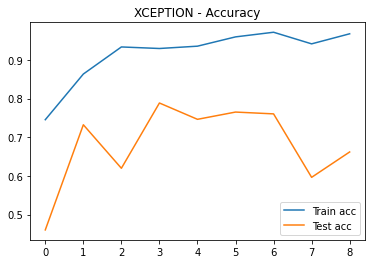

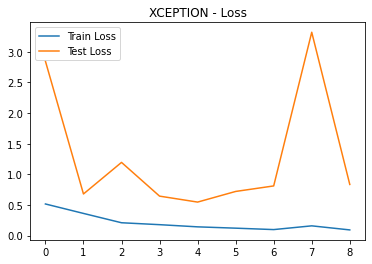

Train Check Range: 500 : 1000
Test Check Range: 214 : 428 

(500, 300, 300, 3)
(212, 300, 300, 3)


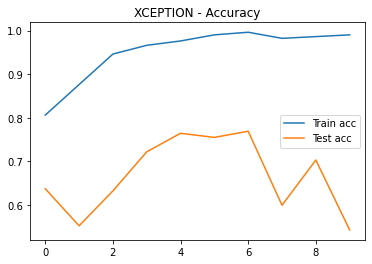

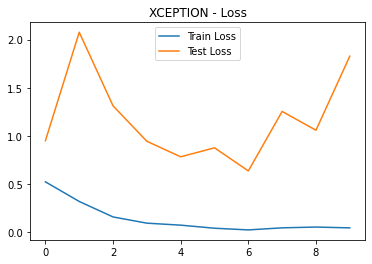

Train Check Range: 1000 : 1500
Test Check Range: 428 : 642 

(499, 300, 300, 3)
(214, 300, 300, 3)


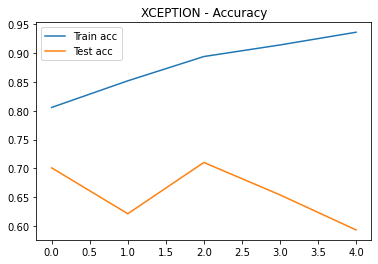

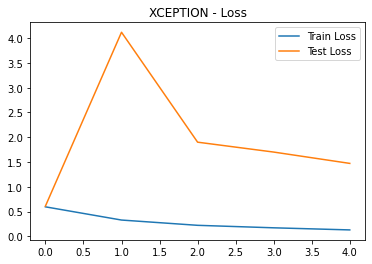

Train Check Range: 1500 : 2000
Test Check Range: 642 : 856 

(500, 300, 300, 3)
(213, 300, 300, 3)


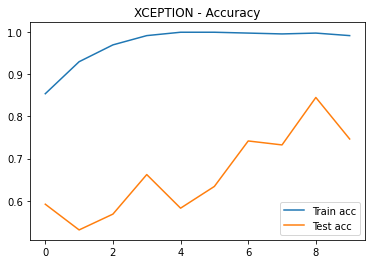

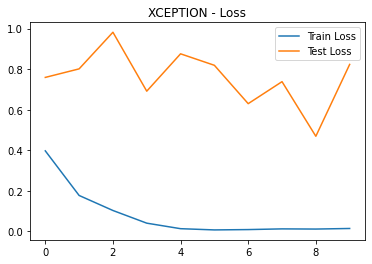

Train Check Range: 2000 : 2500
Test Check Range: 856 : 1070 

(500, 300, 300, 3)
(214, 300, 300, 3)


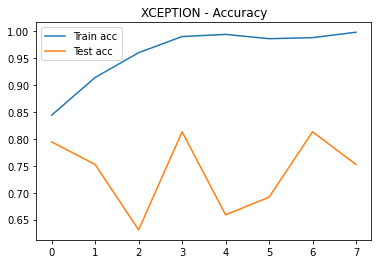

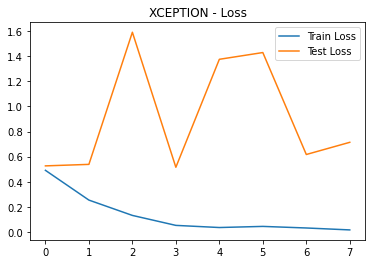

Train Check Range: 2500 : 3000
Test Check Range: 1070 : 1284 

(500, 300, 300, 3)
(214, 300, 300, 3)


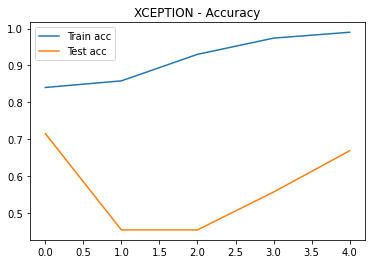

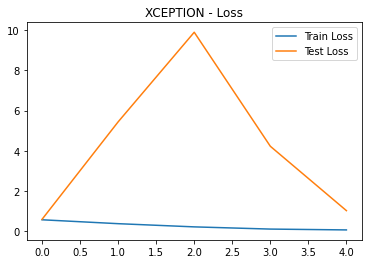

Train Check Range: 3000 : 3500
Test Check Range: 1284 : 1498 

(500, 300, 300, 3)
(214, 300, 300, 3)


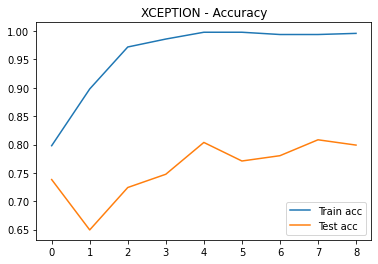

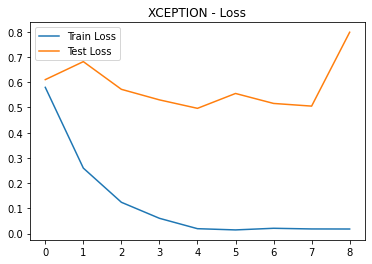

Train Check Range: 3500 : 4000
Test Check Range: 1498 : 1712 

(499, 300, 300, 3)
(213, 300, 300, 3)


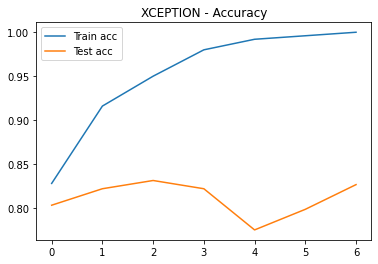

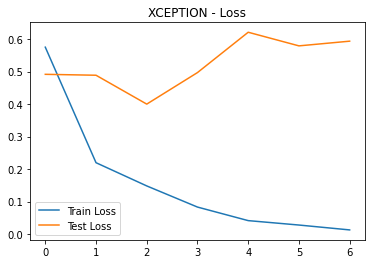

Train Check Range: 4000 : 4500
Test Check Range: 1712 : 1926 

(499, 300, 300, 3)
(214, 300, 300, 3)


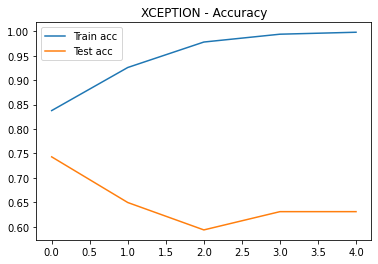

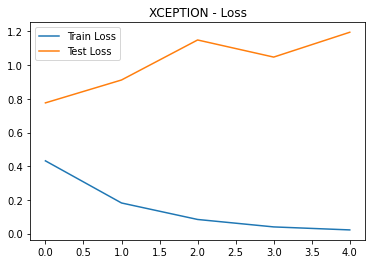

Train Check Range: 4500 : 5000
Test Check Range: 1926 : 2140 

(500, 300, 300, 3)
(214, 300, 300, 3)


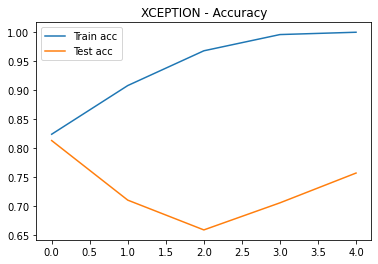

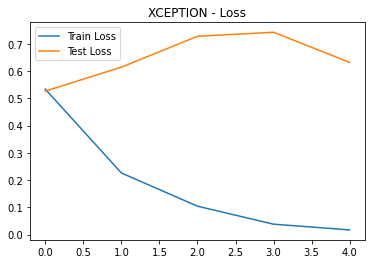

Train Check Range: 5000 : 5500
Test Check Range: 2140 : 2354 

(499, 300, 300, 3)
(214, 300, 300, 3)


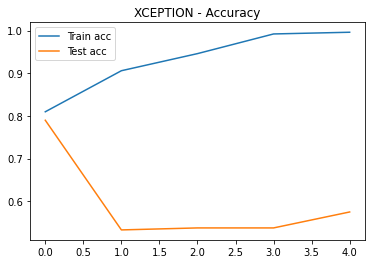

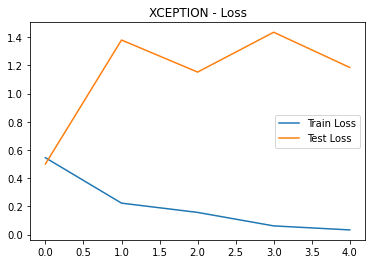

Train Check Range: 5500 : 6000
Test Check Range: 2354 : 2568 

(499, 300, 300, 3)
(214, 300, 300, 3)


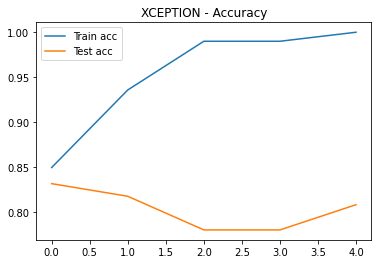

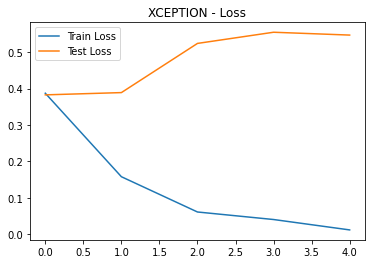

Train Check Range: 6000 : 6500
Test Check Range: 2568 : 2782 

(499, 300, 300, 3)
(214, 300, 300, 3)


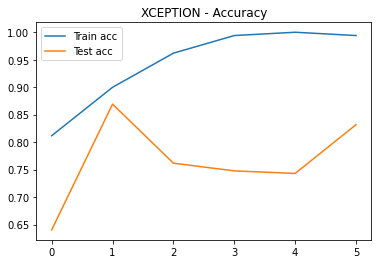

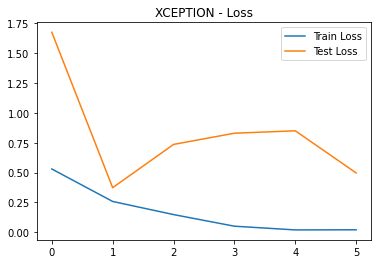

Train Check Range: 6500 : 7000
Test Check Range: 2782 : 2996 

(500, 300, 300, 3)
(212, 300, 300, 3)


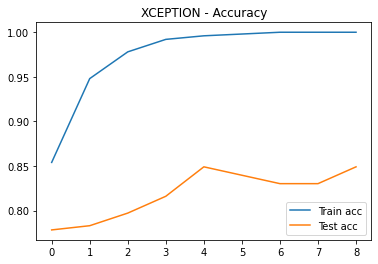

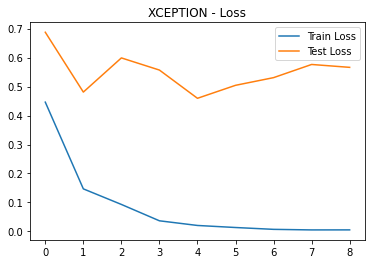

Train Check Range: 7000 : 7500
Test Check Range: 2996 : 3210 

(500, 300, 300, 3)
(214, 300, 300, 3)


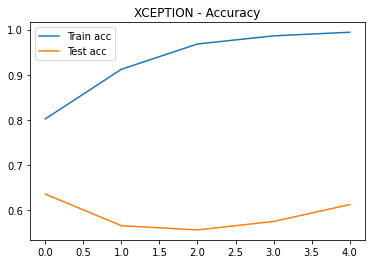

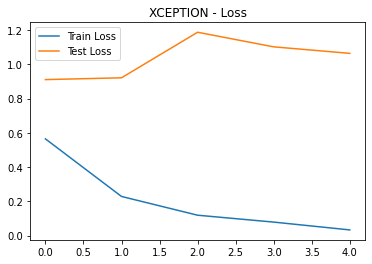

Train Check Range: 7500 : 8000
Test Check Range: 3210 : 3424 

(500, 300, 300, 3)
(214, 300, 300, 3)


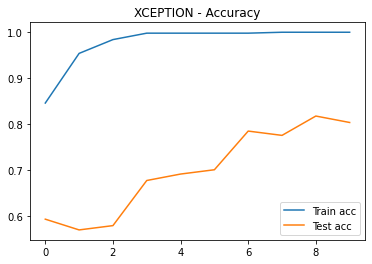

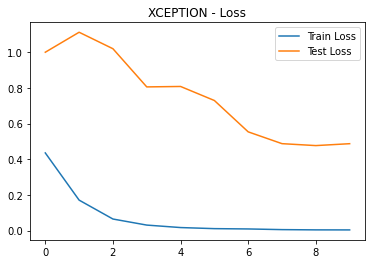

Train Check Range: 8000 : 8500
Test Check Range: 3424 : 3638 

(500, 300, 300, 3)
(214, 300, 300, 3)


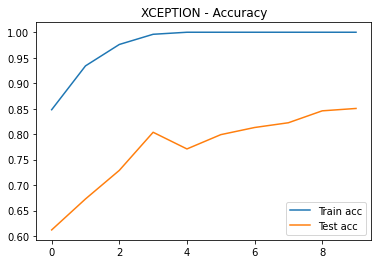

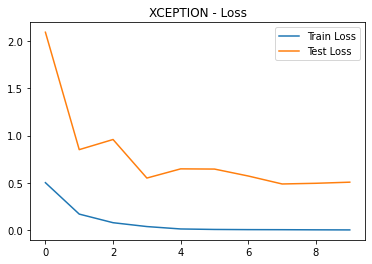

Train Check Range: 8500 : 9000
Test Check Range: 3638 : 3852 

(498, 300, 300, 3)
(213, 300, 300, 3)


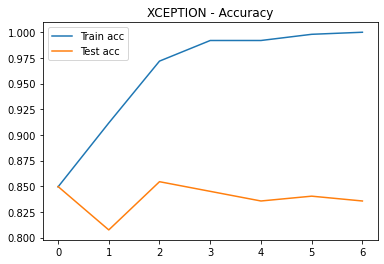

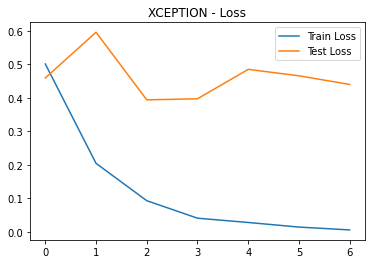

Train Check Range: 9000 : 9500
Test Check Range: 3852 : 4066 

(499, 300, 300, 3)
(214, 300, 300, 3)


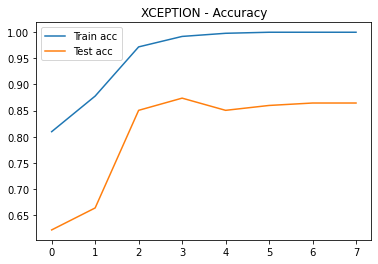

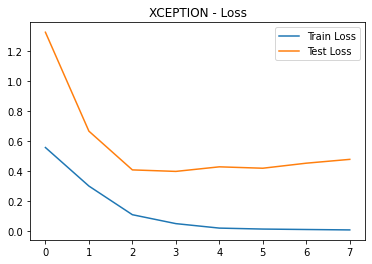

Train Check Range: 9500 : 10000
Test Check Range: 4066 : 4280 

(500, 300, 300, 3)
(214, 300, 300, 3)


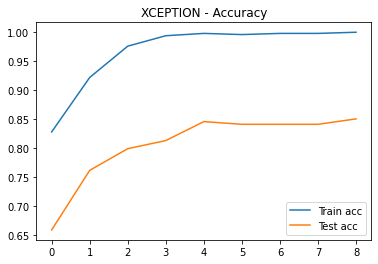

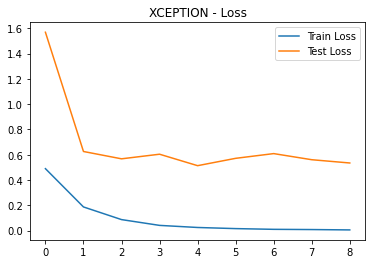

Train Check Range: 10000 : 10500
Test Check Range: 4280 : 4494 

(499, 300, 300, 3)
(214, 300, 300, 3)


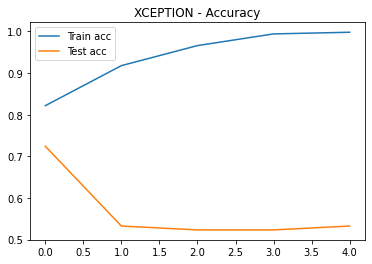

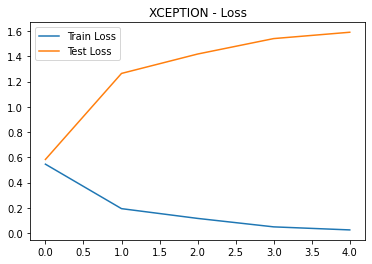

Train Check Range: 10500 : 11000
Test Check Range: 4494 : 4708 

(500, 300, 300, 3)
(213, 300, 300, 3)


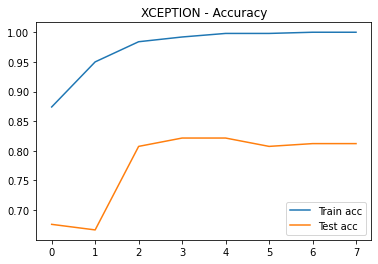

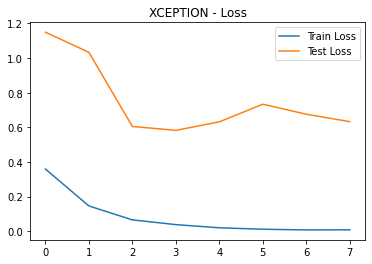

Train Check Range: 11000 : 11500
Test Check Range: 4708 : 4922 

(500, 300, 300, 3)
(214, 300, 300, 3)


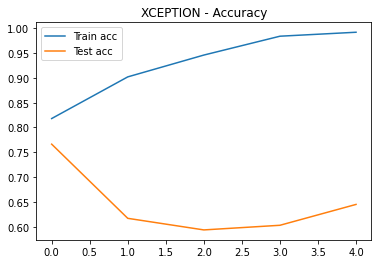

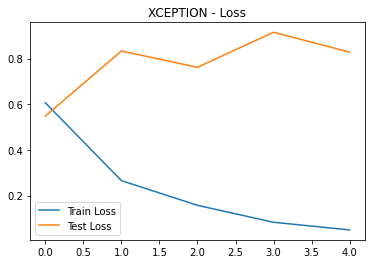

Train Check Range: 11500 : 12000
Test Check Range: 4922 : 5136 

(500, 300, 300, 3)
(213, 300, 300, 3)


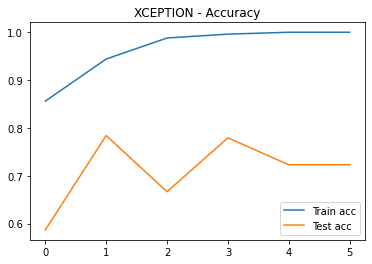

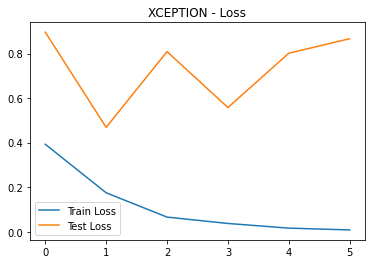

Train Check Range: 12000 : 12500
Test Check Range: 5136 : 5350 

(500, 300, 300, 3)
(213, 300, 300, 3)


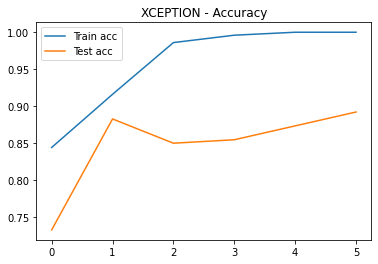

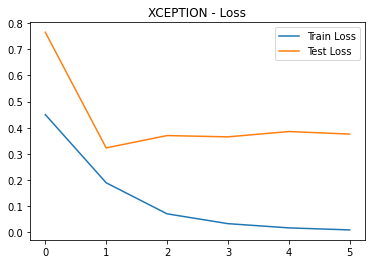

Train Check Range: 12500 : 13000
Test Check Range: 5350 : 5564 

(500, 300, 300, 3)
(214, 300, 300, 3)


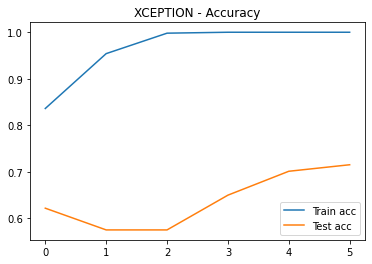

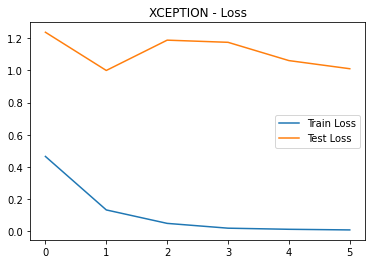

Train Check Range: 13000 : 13500
Test Check Range: 5564 : 5778 

(500, 300, 300, 3)
(214, 300, 300, 3)


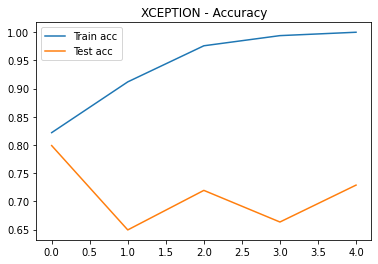

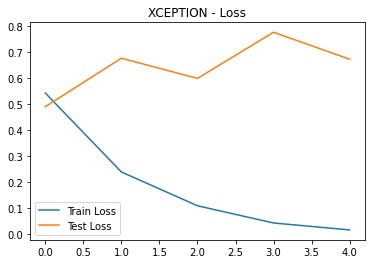

Train Check Range: 13500 : 14000
Test Check Range: 5778 : 5992 

(500, 300, 300, 3)
(214, 300, 300, 3)


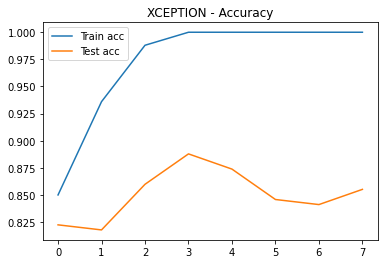

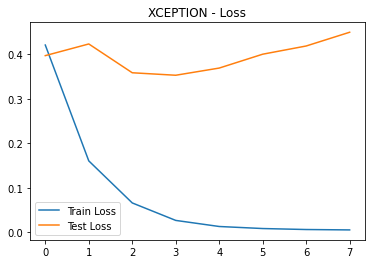

Train Check Range: 14000 : 14500
Test Check Range: 5992 : 6206 

(500, 300, 300, 3)
(214, 300, 300, 3)


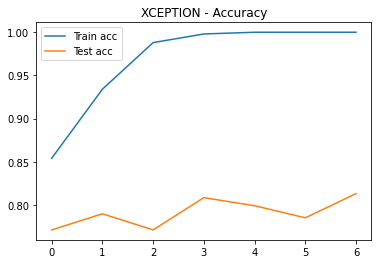

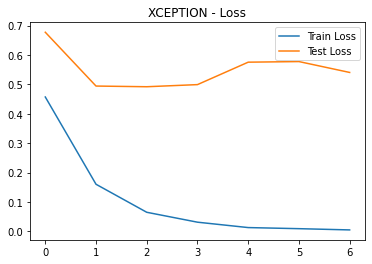

Train Check Range: 14500 : 15000
Test Check Range: 6206 : 6420 

(500, 300, 300, 3)
(214, 300, 300, 3)


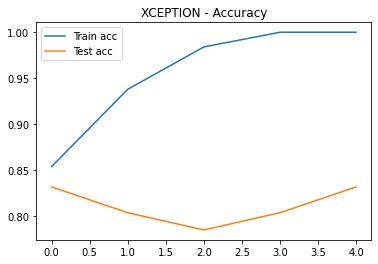

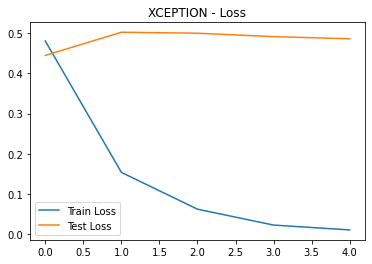

Train Check Range: 15000 : 15500
Test Check Range: 6420 : 6634 

(500, 300, 300, 3)
(212, 300, 300, 3)


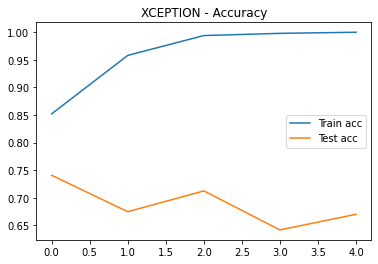

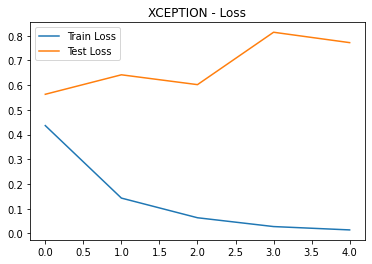

Train Check Range: 15500 : 16000
Test Check Range: 6634 : 6848 

(499, 300, 300, 3)
(212, 300, 300, 3)


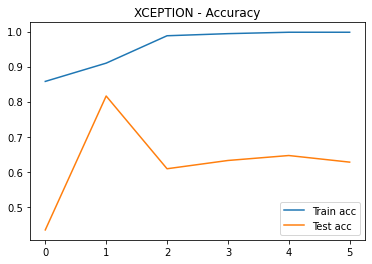

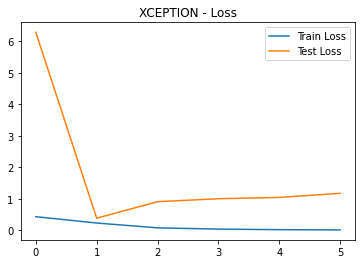

Train Check Range: 16000 : 16500
Test Check Range: 6848 : 7062 

(499, 300, 300, 3)
(214, 300, 300, 3)


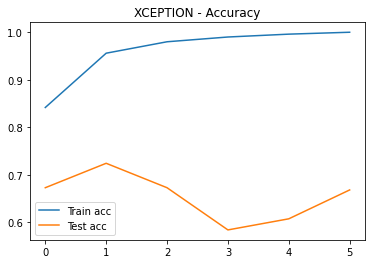

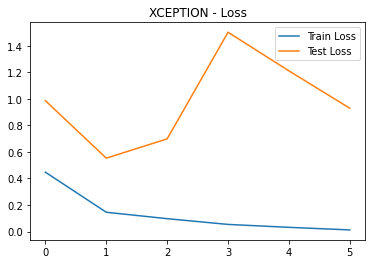

Train Check Range: 16500 : 17000
Test Check Range: 7062 : 7276 

(500, 300, 300, 3)
(214, 300, 300, 3)


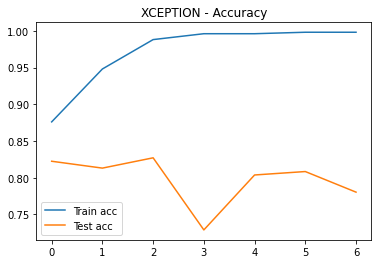

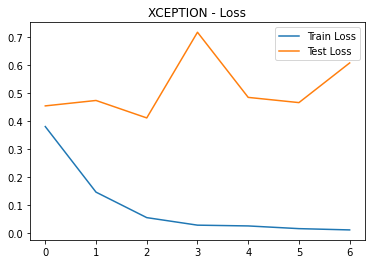

Train Check Range: 17000 : 17500
Test Check Range: 7276 : 7490 

(500, 300, 300, 3)
(213, 300, 300, 3)


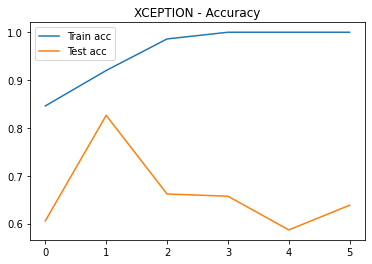

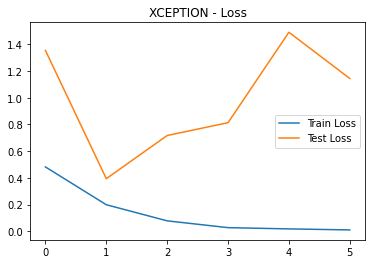

Train Check Range: 17500 : 18000
Test Check Range: 7490 : 7704 

(500, 300, 300, 3)
(214, 300, 300, 3)


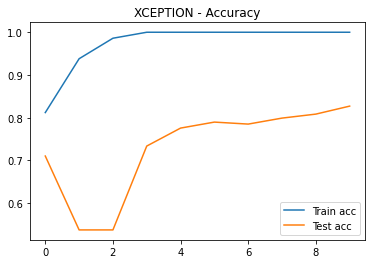

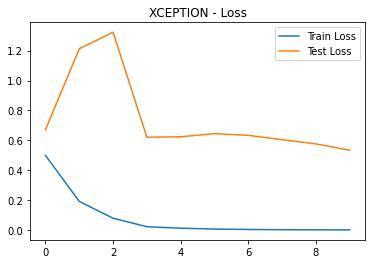

Train Check Range: 18000 : 18500
Test Check Range: 7704 : 7918 

(499, 300, 300, 3)
(214, 300, 300, 3)


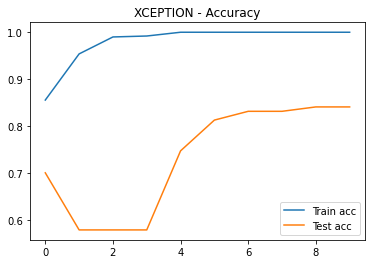

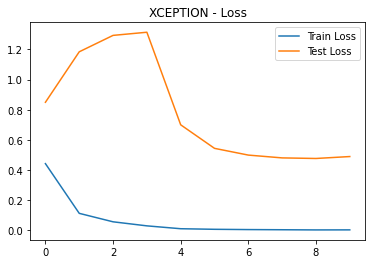

Train Check Range: 18500 : 19000
Test Check Range: 7918 : 8132 

(499, 300, 300, 3)
(214, 300, 300, 3)


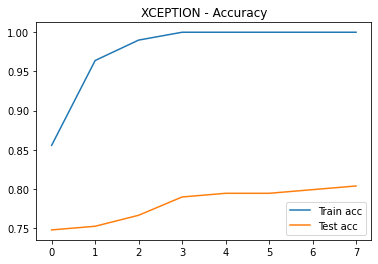

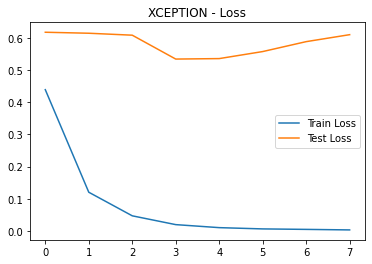

Train Check Range: 19000 : 19500
Test Check Range: 8132 : 8346 

(499, 300, 300, 3)
(214, 300, 300, 3)


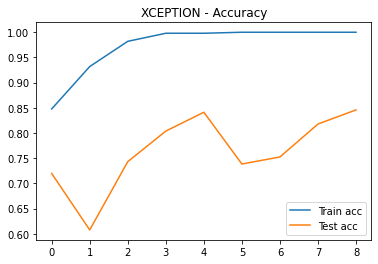

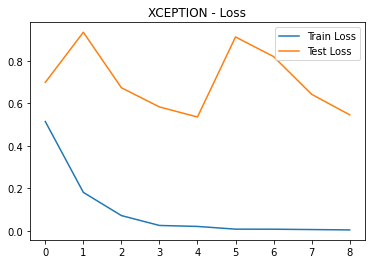

Train Check Range: 19500 : 20000
Test Check Range: 8346 : 8560 

(500, 300, 300, 3)
(214, 300, 300, 3)


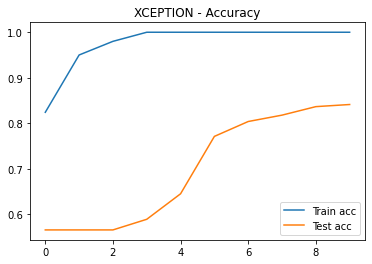

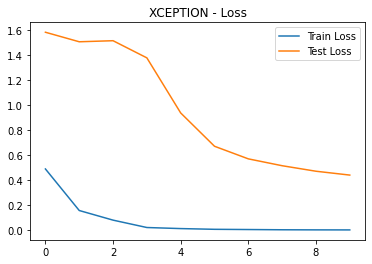

Train Check Range: 20000 : 20500
Test Check Range: 8560 : 8774 

(500, 300, 300, 3)
(213, 300, 300, 3)


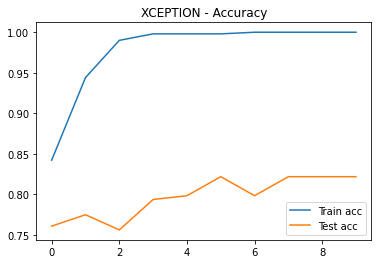

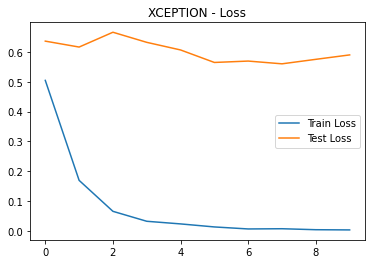

In [ ]:
# Density Prediction
density_train = density_train['density'].map({0: 0, 1: 0, 2: 1, 3: 1})
density_test = density_test['density'].map({0: 0, 1: 0, 2: 1, 3: 1})

prediction_model_run(
    image_dimension=300,
    batch_size=500, 
    train_df=density_train, 
    test_df=density_test, 
    title='Density Prediction', 
    target='density', 
    features=['age', 'laterality', 'view'],
    base_path=base_path,
    image_path_column='img_uri'
    )


In [ ]:
# Density prediction
xception_model_density = load_model(f"{base_path}/models/density_xception_model_v38.h5")

# Density val dataframe batch size
PRED_BATCH_SIZE = 2000
# Number of rounds based on batch size
rounds = density_predict.shape[0] // PRED_BATCH_SIZE
# Left window tracker
left = 0
# Right window tracker
right = PRED_BATCH_SIZE
# Loop based on rounds
for i in range(rounds):
  # Prepare X_test and X_test_image
  X_test = density_predict.loc[left:right, ['age', 'laterality', 'view']]
  X_test_batched_image = construct_image_array(
      density_predict.loc[left:right, 'img_uri'].tolist()
  )
  # Process prediction
  density_predictions = xception_model_density.predict([X_test_batched_image, X_test]).flatten()
  # Store predicted values
  density_predict.loc[left:right, 'density'] = density_predictions.round(2)

  # Update trackers
  left = right
  right += PRED_BATCH_SIZE

(2001, 300, 300, 3)
63/63 [==============================] - 61s 954ms/step
(2000, 300, 300, 3)
63/63 [==============================] - 58s 928ms/step
(2001, 300, 300, 3)
63/63 [==============================] - 58s 922ms/step
(2001, 300, 300, 3)
63/63 [==============================] - 58s 919ms/step
(2001, 300, 300, 3)
63/63 [==============================] - 57s 901ms/step
(2001, 300, 300, 3)
63/63 [==============================] - 59s 932ms/step
(1997, 300, 300, 3)
63/63 [==============================] - 58s 912ms/step
(2001, 300, 300, 3)
63/63 [==============================] - 59s 940ms/step
(2001, 300, 300, 3)
63/63 [==============================] - 59s 935ms/step
(2001, 300, 300, 3)
63/63 [==============================] - 58s 925ms/step
(2001, 300, 300, 3)
63/63 [==============================] - 58s 918ms/step
(2001, 300, 300, 3)
63/63 [==============================] - 60s 946ms/step


In [15]:
xception_model_density = load_model(f"{base_path}/models/Density Model/density_xception_model_v38.h5")

X_test = density_predict[['age', 'laterality', 'view']]
X_test_batched_image = construct_image_array(
    density_predict['img_uri'].tolist()
)
# Process prediction
density_predictions = xception_model_density.predict([X_test_batched_image, X_test]).flatten()

den_test = pd.DataFrame()
den_test['density'] = density_predict['density']
den_test['pred_density'] = density_predictions

7/7 [==============================] - 8s 913ms/step


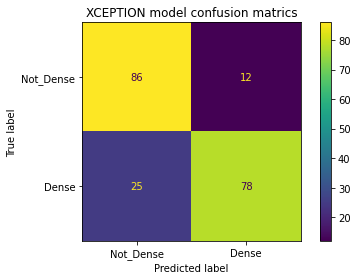

In [42]:
# Plot confusion matrix for predicted and true values
plot_confusion_matrix(den_test['density'].map({0: 0, 1: 0, 2: 1, 3: 1}), den_test['pred_density'].map(threshold), ['Not_Dense', 'Dense'])

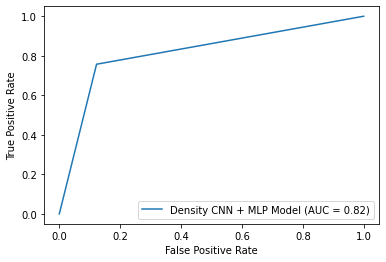

In [43]:
# Plot ROC curve
roc_curve_plot(den_test['density'].map({0: 0, 1: 0, 2: 1, 3: 1}), den_test['pred_density'].map(threshold), 'Density CNN + MLP Model')

In [44]:
print_classification_report(
    den_test['density'].map({0: 0, 1: 0, 2: 1, 3: 1}), den_test['pred_density'].map(threshold),
    [1, 0])

Classifier Report:
              precision    recall  f1-score   support

           1       0.87      0.76      0.81       103
           0       0.77      0.88      0.82        98

    accuracy                           0.82       201
   macro avg       0.82      0.82      0.82       201
weighted avg       0.82      0.82      0.82       201



In [ ]:
# Drop missing predictions
density_predict.dropna(inplace=True)

In [ ]:
# Store predicted values to csv 
density_predict.to_csv(f'{base_path}/density_with_preds.csv', index=False)

In [ ]:
# Merge all density dataframes
merged_df = pd.concat([
    density_train, 
    density_test, 
    density_predict
])

<AxesSubplot:ylabel='Frequency'>

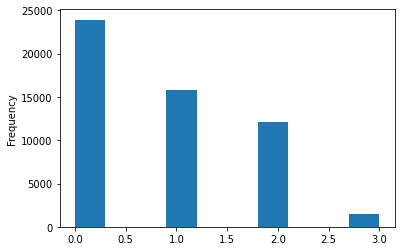

In [ ]:
# Plot density distribution
merged_df['density'].round(0).plot(kind='hist')

In [ ]:
# Save merged dataframe containing density
merged_df.to_csv(f'{base_path}/density_df.csv', index=False)

In [12]:
# Read dataframe containing density
merged_df = pd.read_csv(f'{base_path}/density_df.csv')

In [12]:
# Round density values
merged_df['density'] = merged_df['density'].round(0)

----
Cancer Prediction - Under Sampled Dataset

In [45]:
# Load under sampled dataframes
train_df = pd.read_csv(f'{base_path}/model_data/under_train.csv')
test_df = pd.read_csv(f'{base_path}/model_data/under_test.csv')
val_df = pd.read_csv(f'{base_path}/model_data/under_val.csv')

In [46]:
# Check columns
train_df.head(1)

,index,patient_id,image_id,laterality,view,age,cancer
0,344,11265,213091987,0,1,72.0,0


In [47]:
# Set the target
target_column = 'cancer'

In [48]:
# Check shapes of dataframes
train_df.shape, test_df.shape, val_df.shape

((1618, 7), (347, 7), (347, 7))

In [49]:
# Merge with density dataset
train_df = train_df.merge(
    merged_df[['patient_id', 'image_id', 'img_uri', 'density', 'implant']], 
    on=['patient_id', 'image_id'])

test_df = test_df.merge(
    merged_df[['patient_id', 'image_id', 'img_uri', 'density', 'implant']], 
    on=['patient_id', 'image_id'])

val_df = val_df.merge(
    merged_df[['patient_id', 'image_id', 'img_uri', 'density', 'implant']], 
    on=['patient_id', 'image_id'])

In [50]:
# Check columns after merge
train_df.head(1)

,index,patient_id,image_id,laterality,view,age,cancer,img_uri,density,implant
0,344,11265,213091987,0,1,72.0,0,/content/drive/MyDrive/General Assembly/breast...,0.03,0


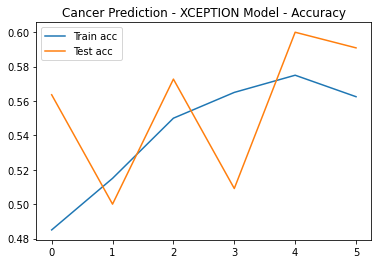

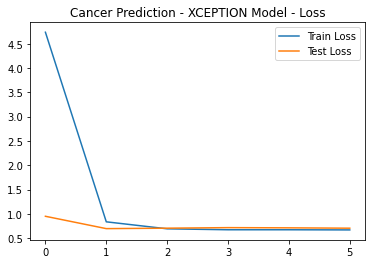

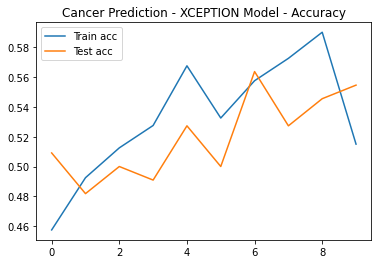

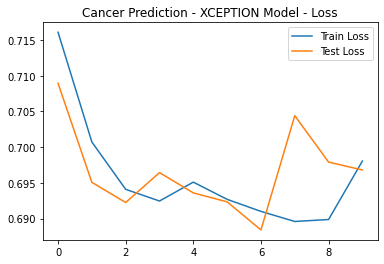

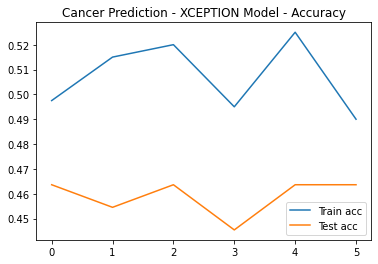

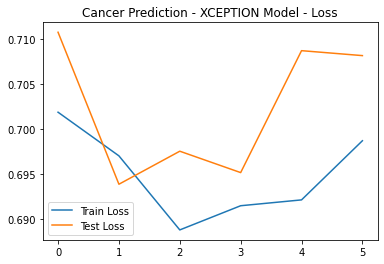

In [ ]:
# Run prediction model(s)
prediction_model_run(
    image_dimension=300,
    batch_size=400, 
    train_df=train_df, 
    test_df=test_df, 
    title='Cancer Prediction', 
    target='cancer',
    features=['age', 'laterality', 'view', 'density'],
    base_path=base_path,
    image_path_column='img_uri'
    )

In [51]:
# Cancer prediction
xception_model_cancer = load_model(f"{base_path}/models/Under Sampled Dataset/cancer_xception_model_v2.h5")
X_test = val_df[['age', 'laterality', 'view', 'density']]

X_test_batched_image = construct_image_array(
    val_df['img_uri'].tolist()
)

cancer_predictions = xception_model_cancer.predict([X_test_batched_image, X_test]).flatten()

val_df['cancer_pred'] = cancer_predictions.round(16)

11/11 [==============================] - 11s 951ms/step


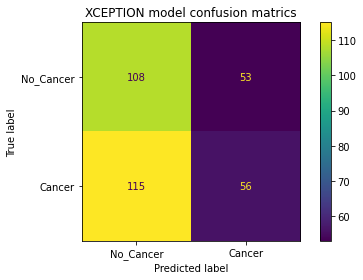

In [69]:
# Plot confusion matrix for predicted and true values
plot_confusion_matrix(val_df['cancer'], val_df['cancer_pred'].map(threshold), ['No_Cancer', 'Cancer'])

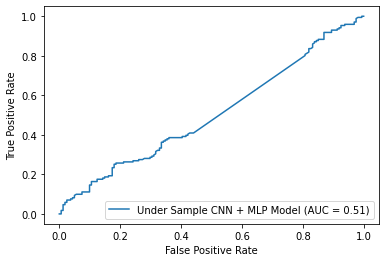

In [70]:
# Plot ROC curve
roc_curve_plot(val_df['cancer'], val_df['cancer_pred'], 'Under Sample CNN + MLP Model')

In [71]:
print_classification_report(val_df['cancer'], val_df['cancer_pred'].round(), [0, 1])

Classifier Report:
              precision    recall  f1-score   support

           0       0.57      0.13      0.21       161
           1       0.53      0.91      0.67       171

    accuracy                           0.53       332
   macro avg       0.55      0.52      0.44       332
weighted avg       0.55      0.53      0.45       332



----
Cancer Prediction - Over Sampled Dataset

In [104]:
# Load over sampled dataframes
train_df = pd.read_csv(f'{base_path}/model_data/over_train.csv')
test_df = pd.read_csv(f'{base_path}/model_data/over_test.csv')
val_df = pd.read_csv(f'{base_path}/model_data/over_val.csv')

In [105]:
# Check columns
train_df.head(1)

,index,patient_id,image_id,laterality,view,age,cancer
0,44731,38561,468334037,1,0,68.0,0


In [106]:
# Set target
target_column = 'cancer'

In [107]:
# Check shapes
train_df.shape, test_df.shape, val_df.shape

((74865, 7), (16043, 7), (16042, 7))

In [108]:
# Merge with density dataset
train_df = train_df.merge(
    merged_df[['patient_id', 'image_id', 'img_uri', 'density']], 
    on=['patient_id', 'image_id'])

test_df = test_df.merge(
    merged_df[['patient_id', 'image_id', 'img_uri', 'density']], 
    on=['patient_id', 'image_id'])

val_df = val_df.merge(
    merged_df[['patient_id', 'image_id', 'img_uri', 'density']], 
    on=['patient_id', 'image_id'])

83683744/83683744 [==============================] - 0s 0us/step


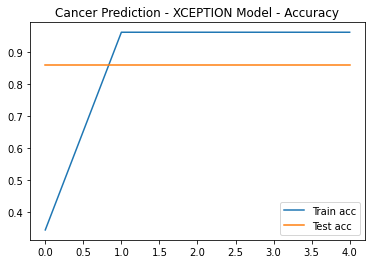

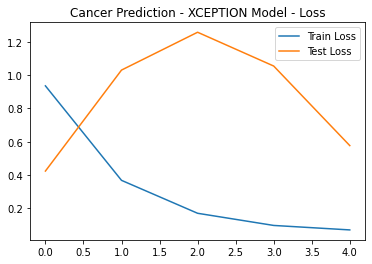

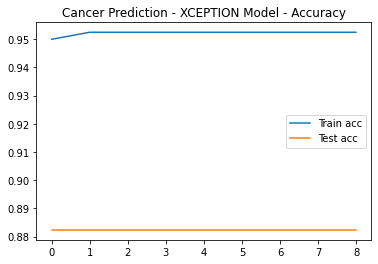

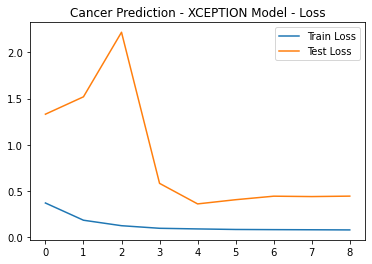

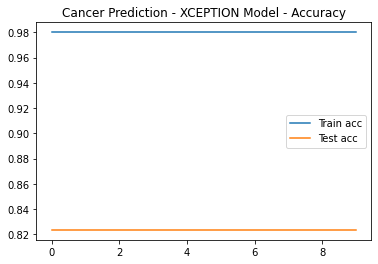

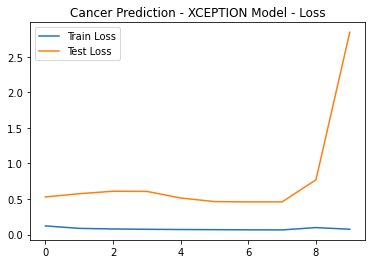

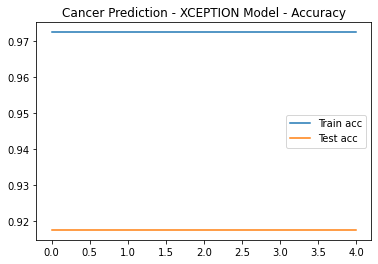

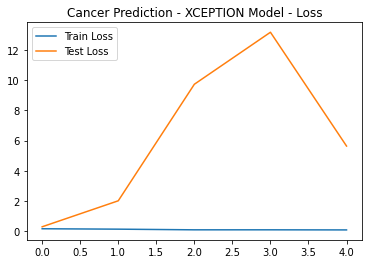

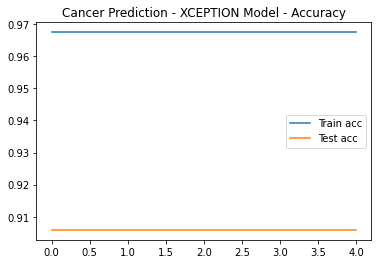

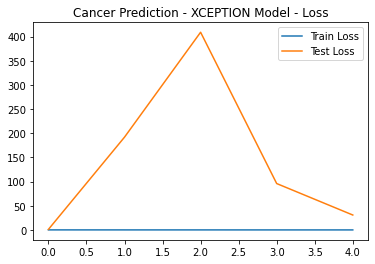

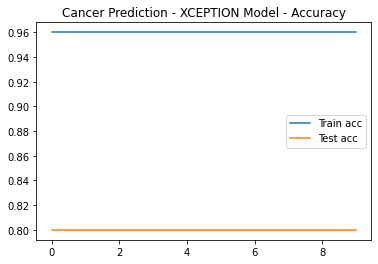

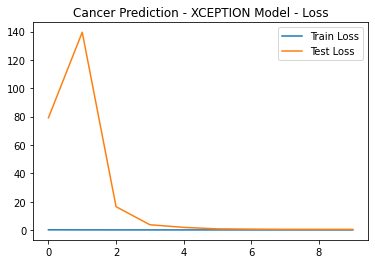

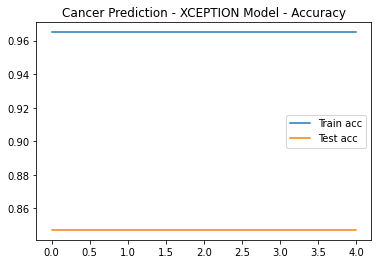

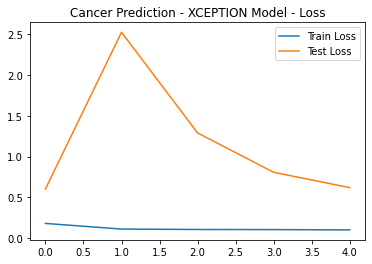

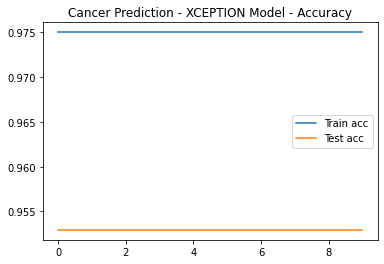

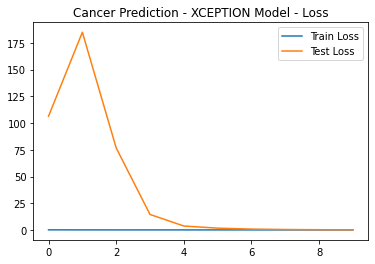

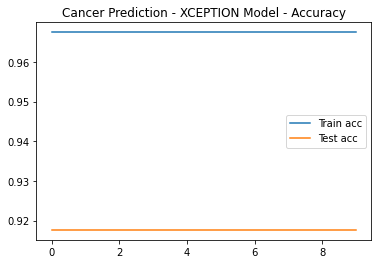

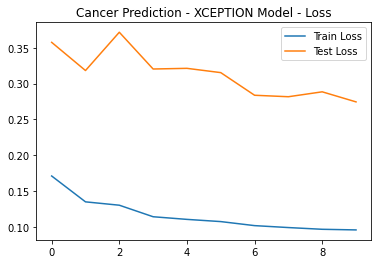

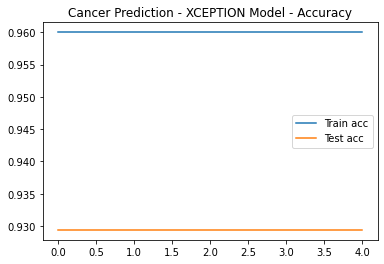

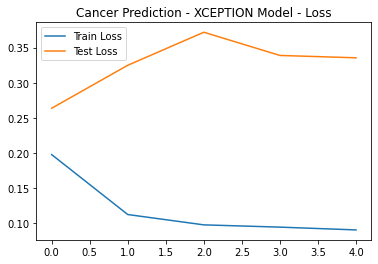

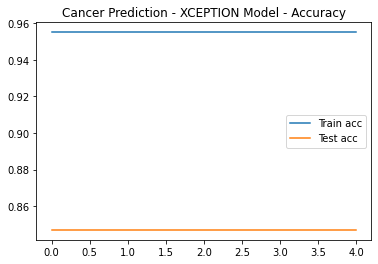

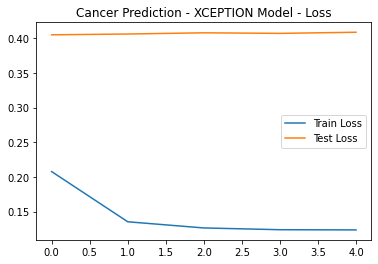

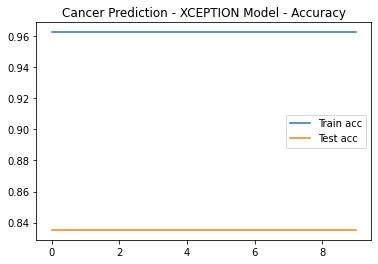

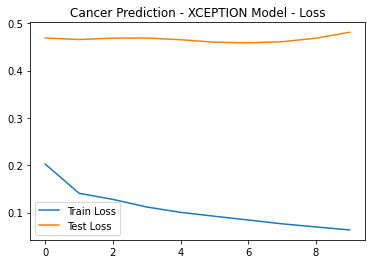

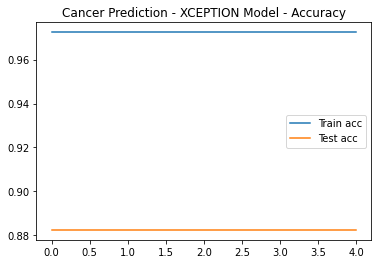

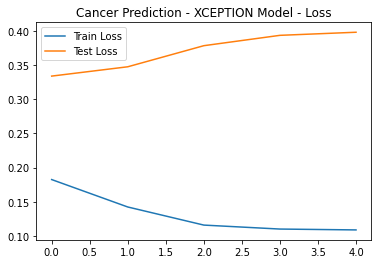

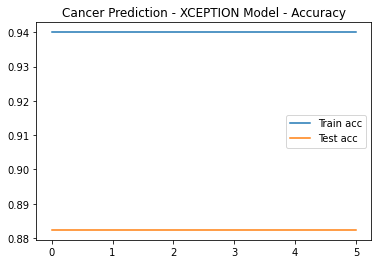

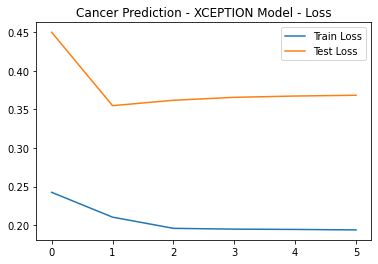

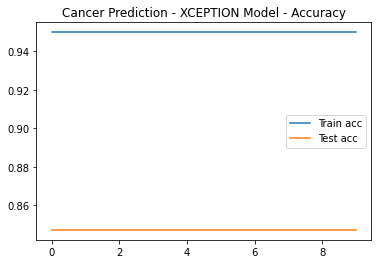

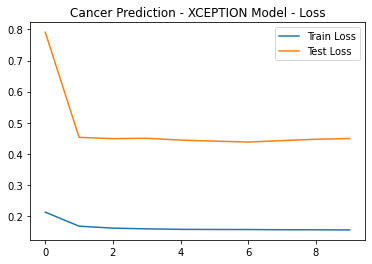

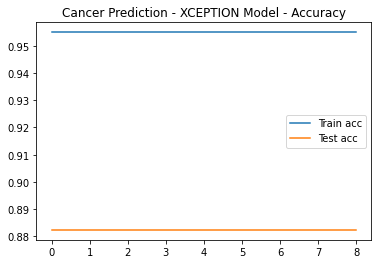

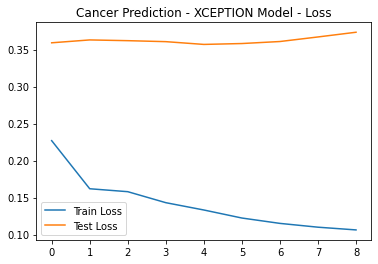

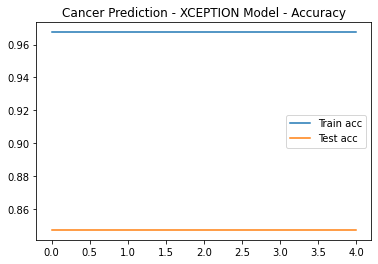

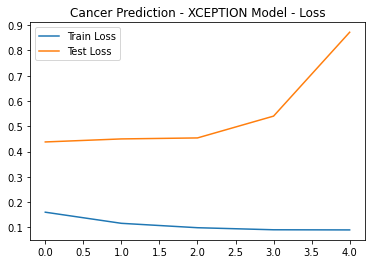

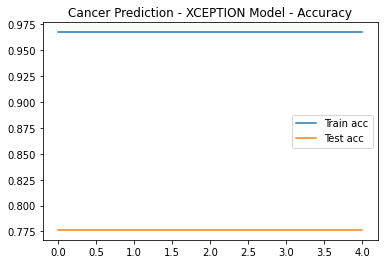

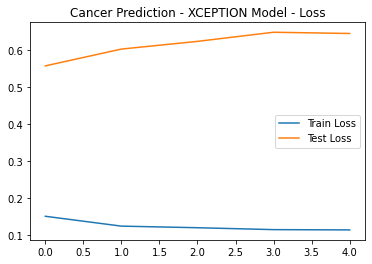

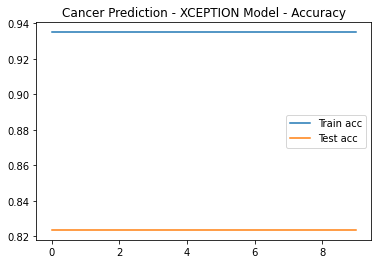

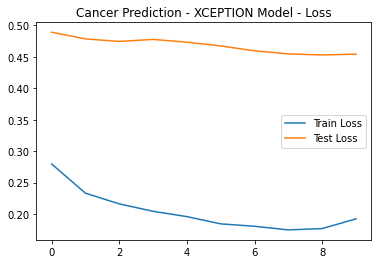

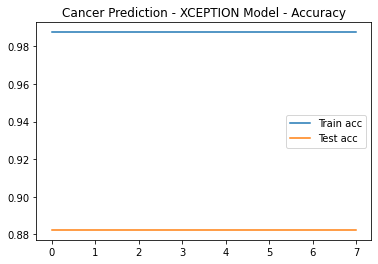

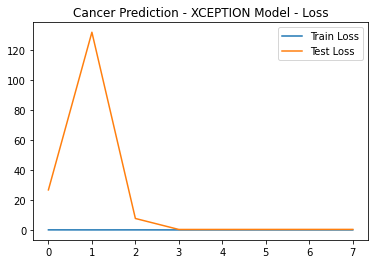

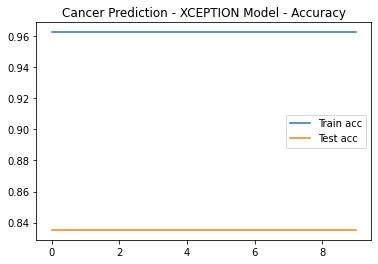

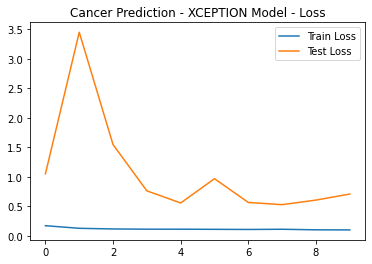

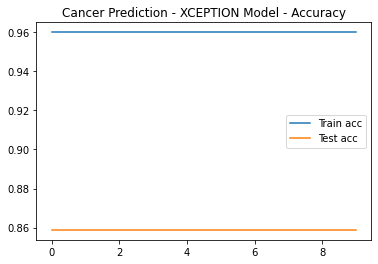

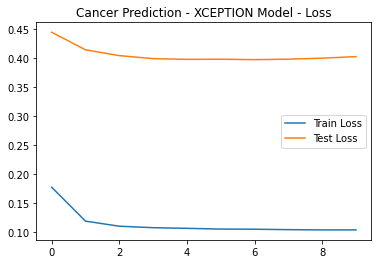

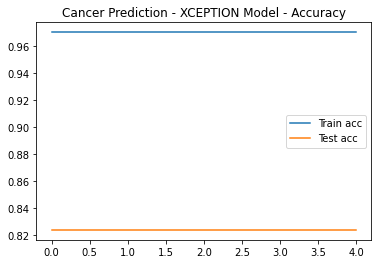

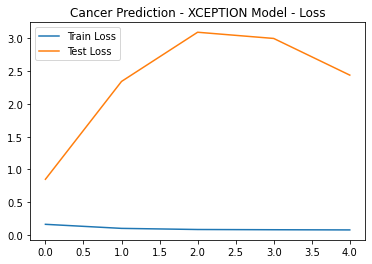

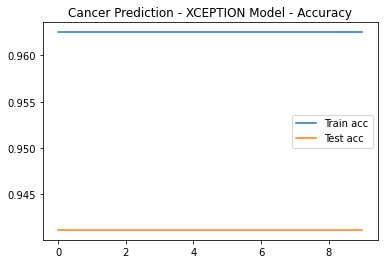

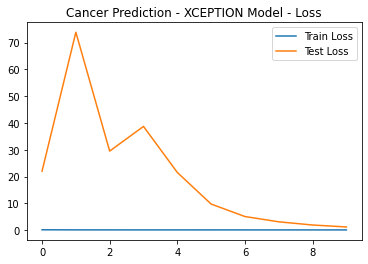

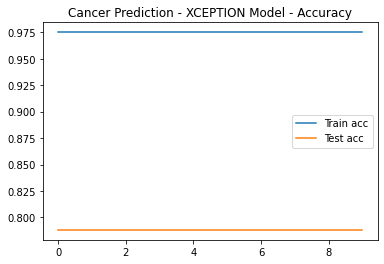

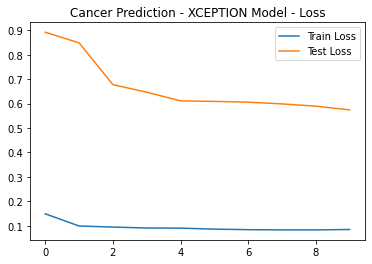

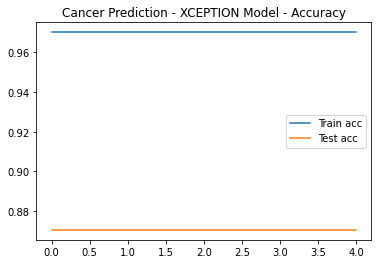

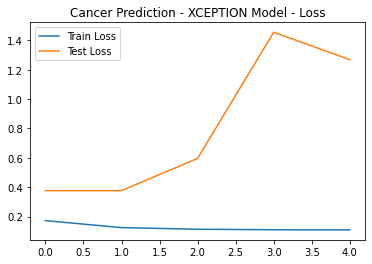

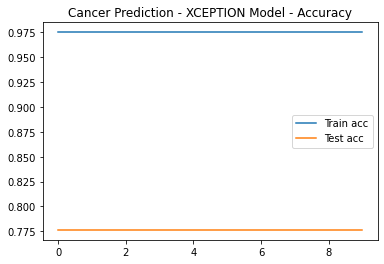

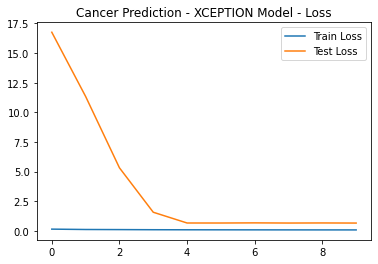

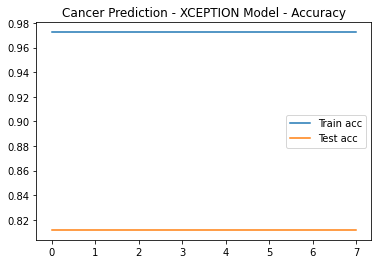

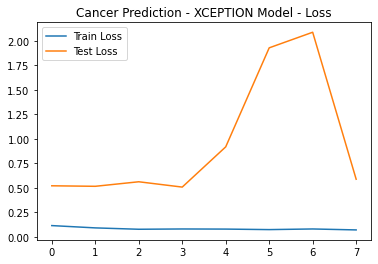

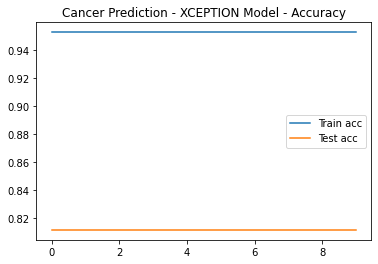

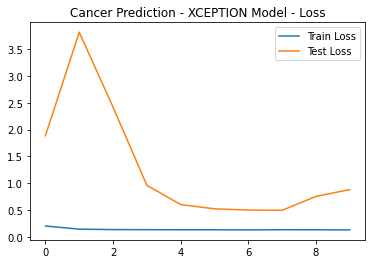

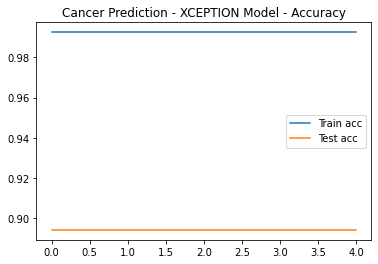

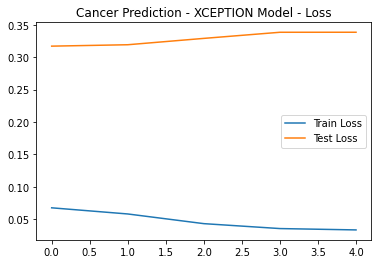

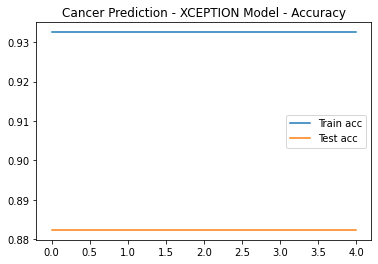

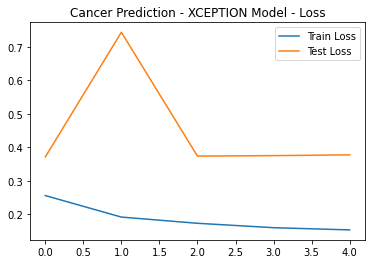

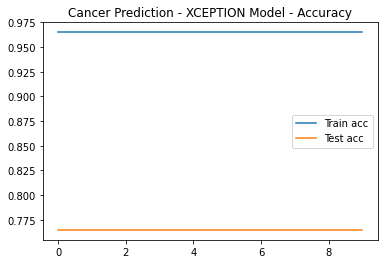

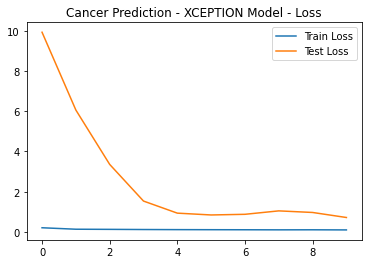

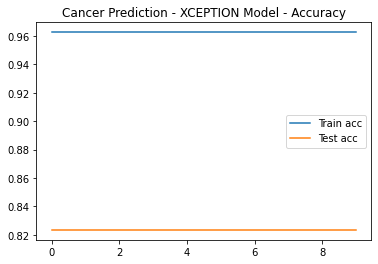

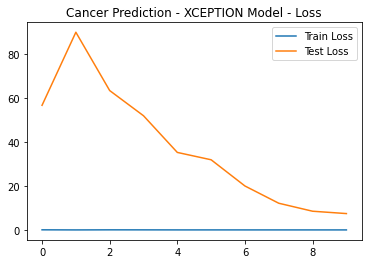

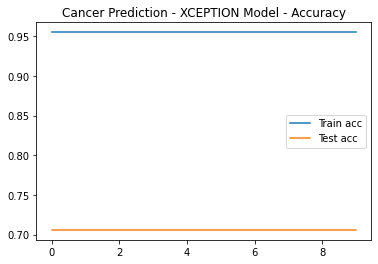

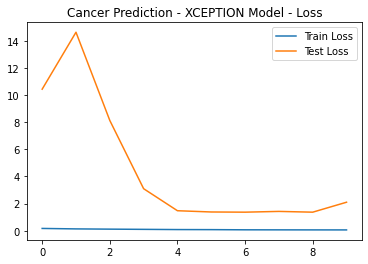

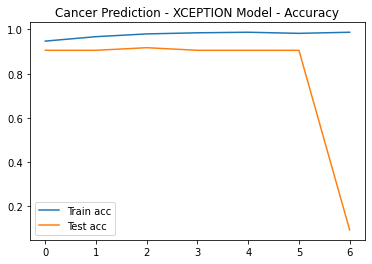

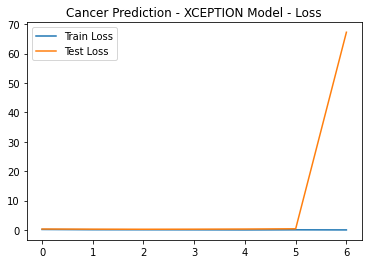

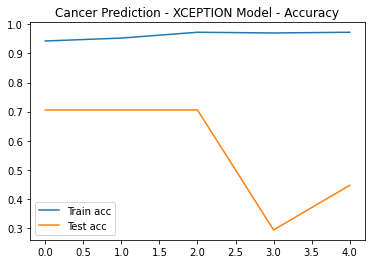

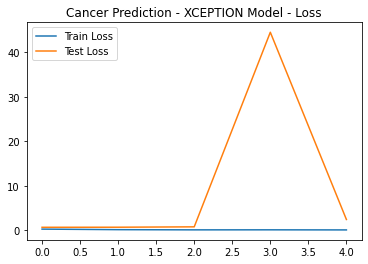

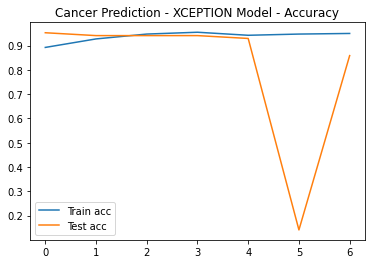

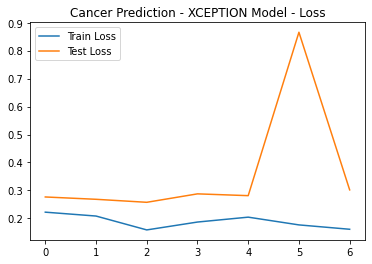

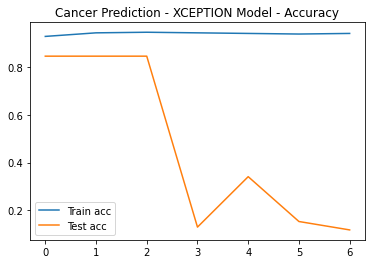

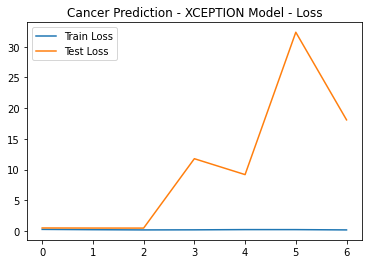

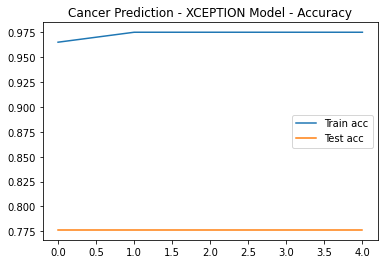

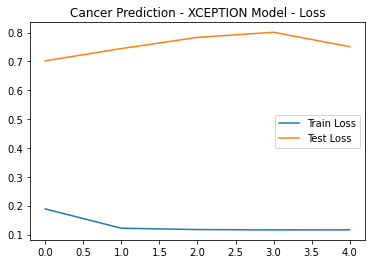

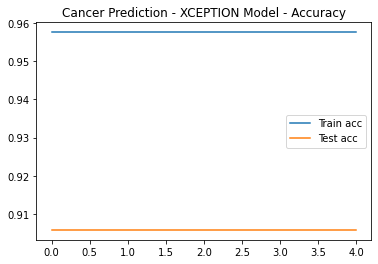

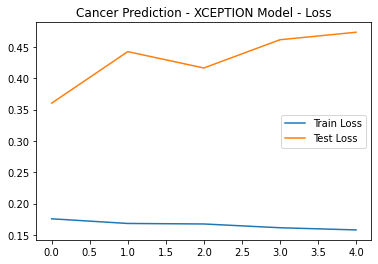

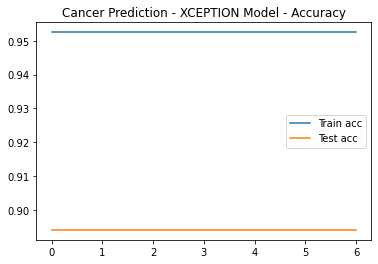

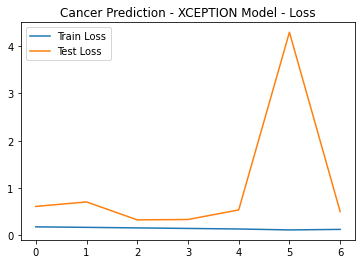

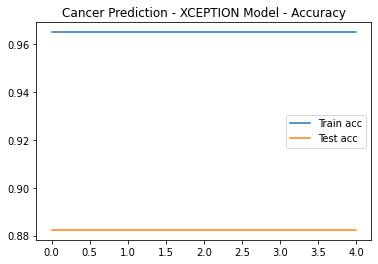

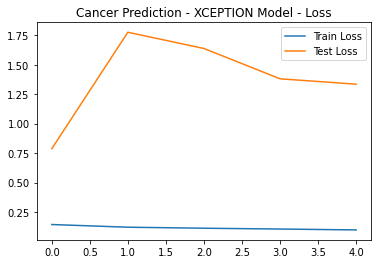

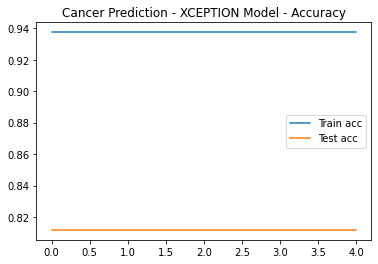

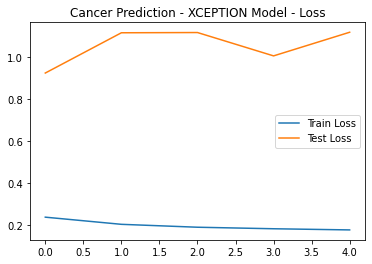

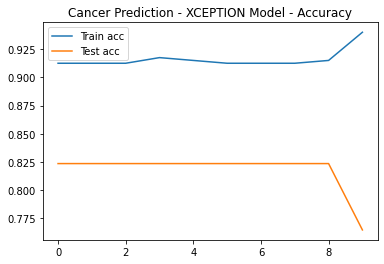

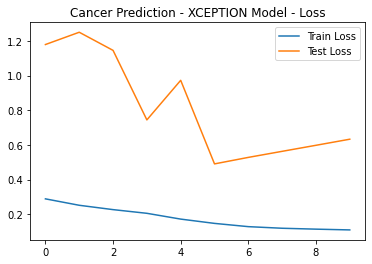

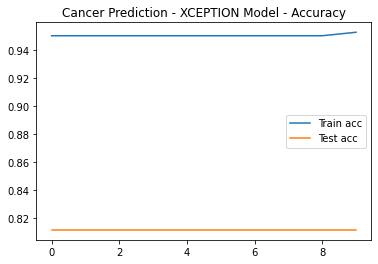

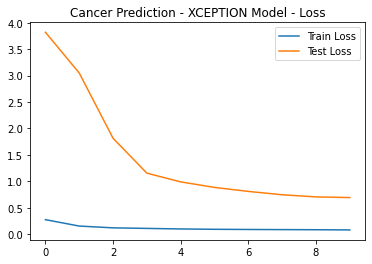

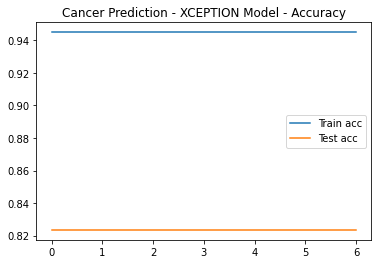

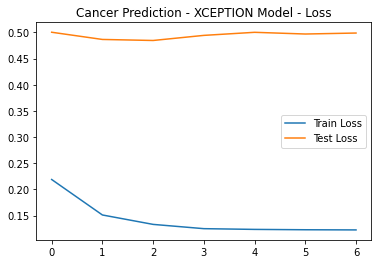

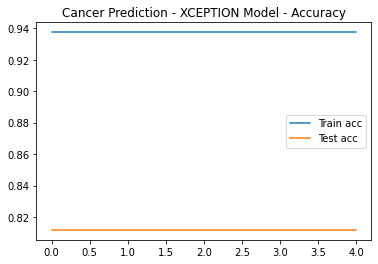

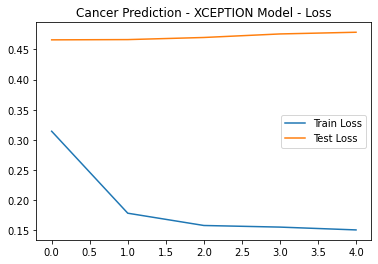

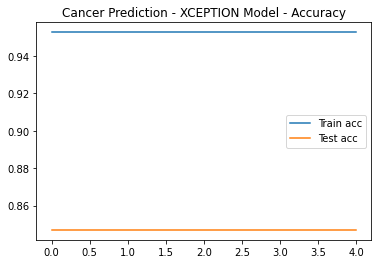

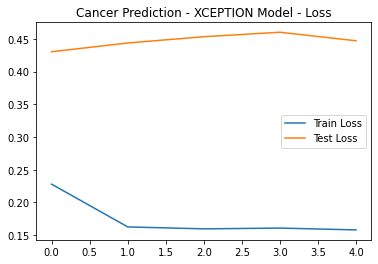

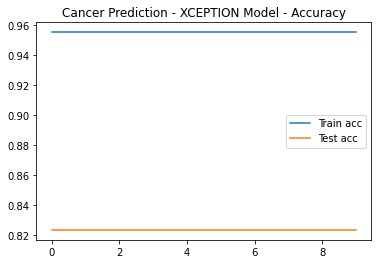

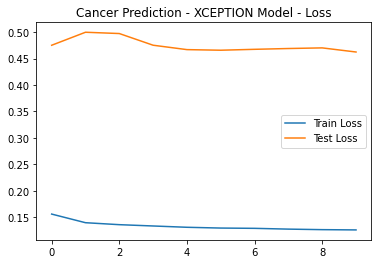

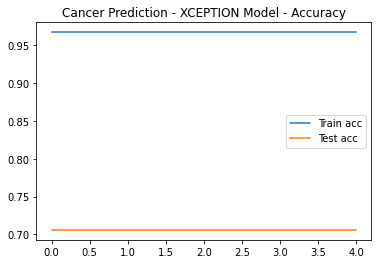

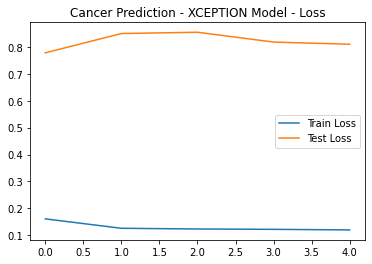

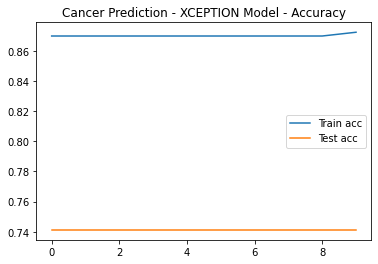

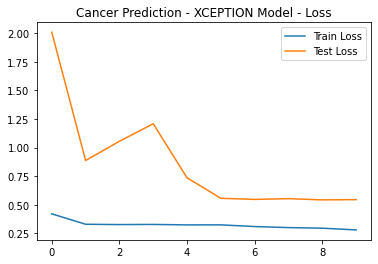

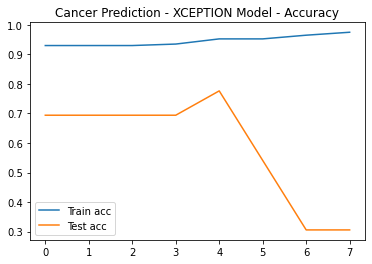

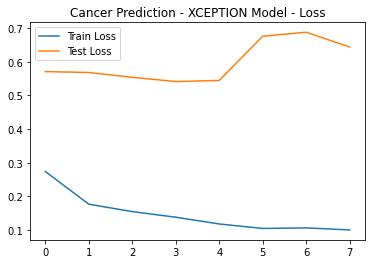

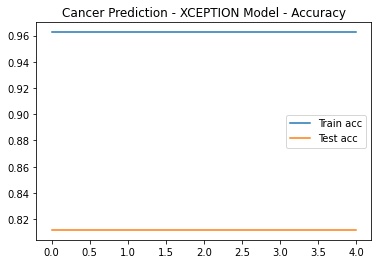

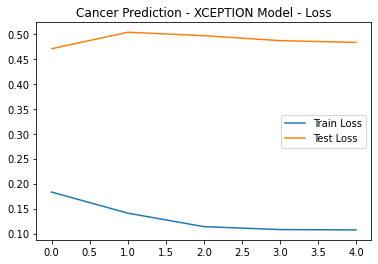

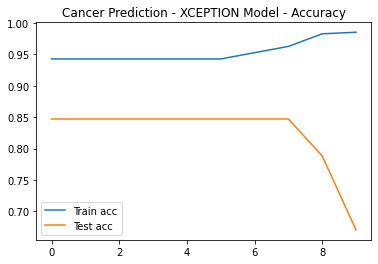

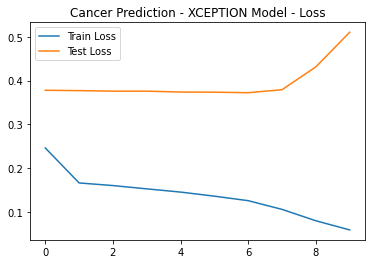

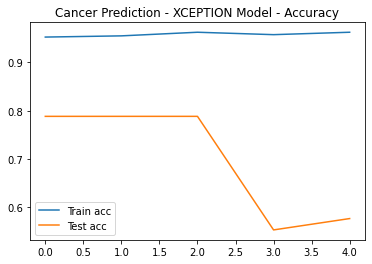

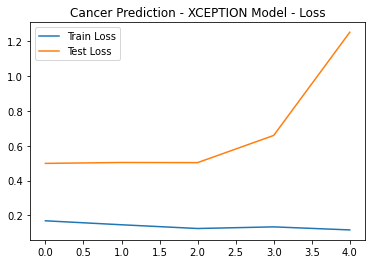

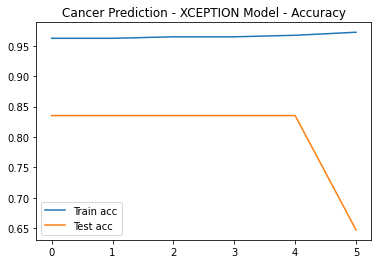

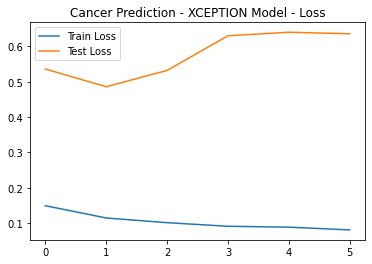

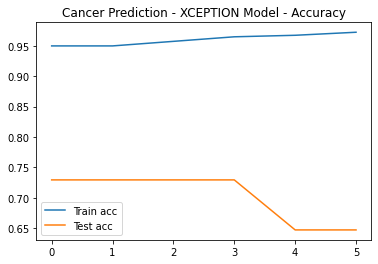

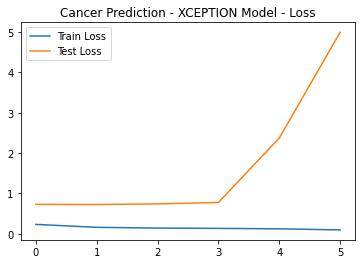

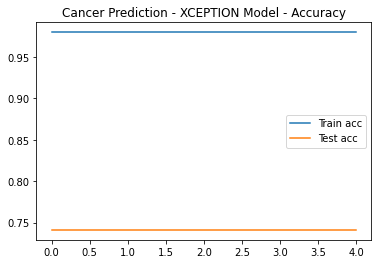

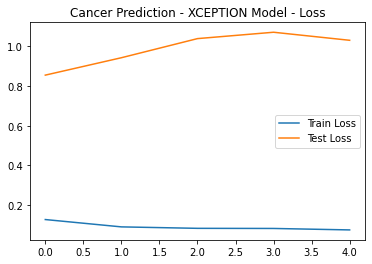

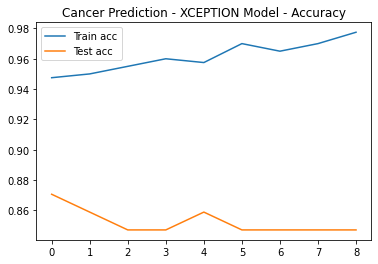

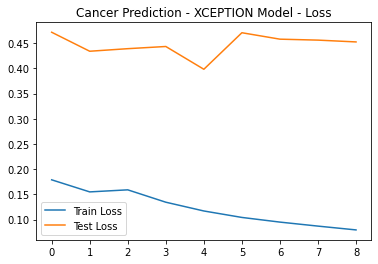

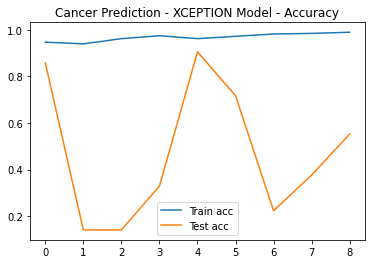

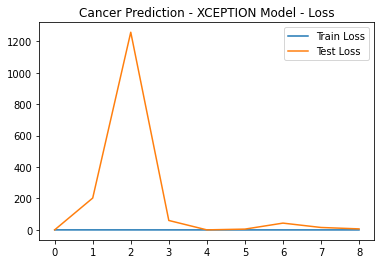

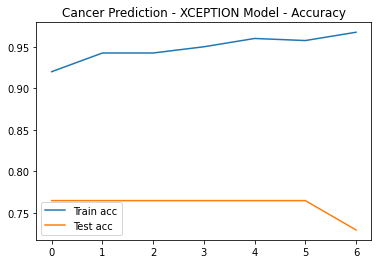

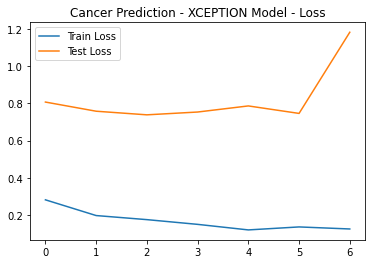

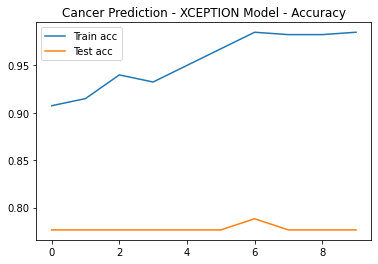

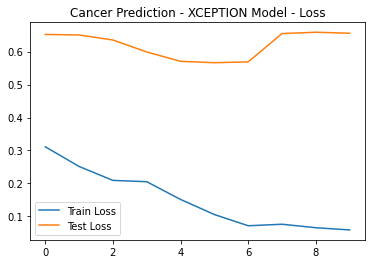

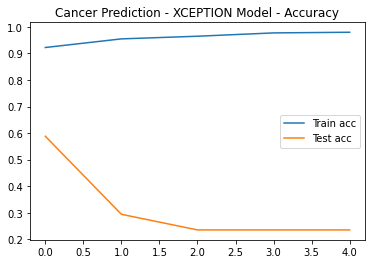

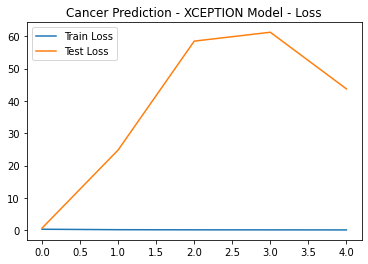

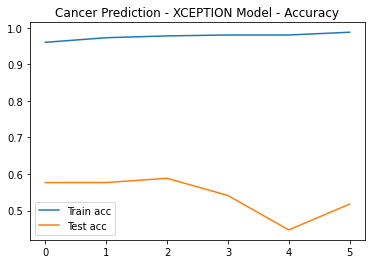

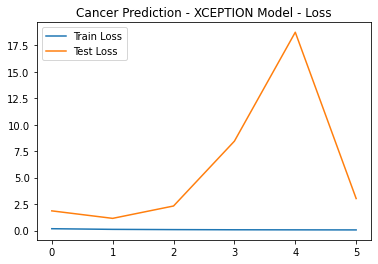

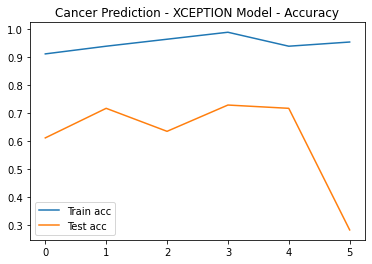

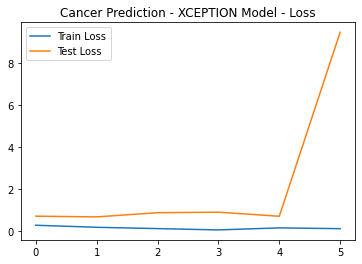

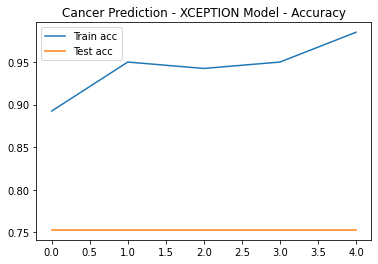

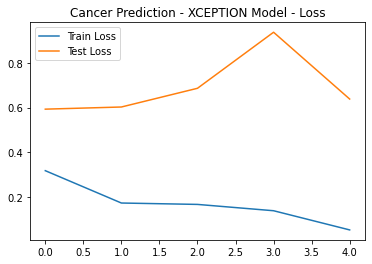

FailedPreconditionError: ignored

In [19]:
# Run prediction model
prediction_model_run(
    image_dimension=300,
    batch_size=400, 
    train_df=train_df, 
    test_df=test_df, 
    title='Cancer Prediction', 
    target='cancer',
    features=['age', 'laterality', 'view', 'density'],
    base_path=base_path,
    image_path_column='img_uri'
    )

In [109]:
# Cancer prediction
xception_model_cancer = load_model(f"{base_path}/models/Over Sampled Dataset/cancer_xception_model_v57.h5")

# Cancer val dataframe batch size
PRED_BATCH_SIZE = 2000
# Number of rounds based on batch size
rounds = val_df.shape[0] // PRED_BATCH_SIZE
# Left window tracker
left = 0
# Right window tracker
right = PRED_BATCH_SIZE
# Loop based on rounds
for i in range(rounds):
  # Prepare X_test and X_test_image for given batch size
  X_test = val_df.loc[left:right, ['age', 'laterality', 'view', 'density']]

  X_test_batched_image = construct_image_array(
      val_df.loc[left:right, 'img_uri'].tolist()
  )

  cancer_predictions = xception_model_cancer.predict([X_test_batched_image, X_test]).flatten()

  val_df.loc[left:right, 'cancer_pred'] = cancer_predictions.round(16)

  if i == 1:
    break

  left = right
  right += PRED_BATCH_SIZE

63/63 [==============================] - 68s 1s/step


In [110]:
val_df.dropna(inplace=True)

In [111]:
val_df['cancer'].value_counts(normalize=True)

1    0.855786
0    0.144214
Name: cancer, dtype: float64

In [112]:
val_df['cancer_pred'].round().value_counts(normalize=True)

1.0    0.99825
0.0    0.00175
Name: cancer_pred, dtype: float64

In [113]:
val_df['cancer_pred'].sort_values().unique()

array([0.4891246 , 0.5018028 , 0.5458934 , ..., 0.99151194, 0.9918364 ,
       0.99187005], dtype=float32)

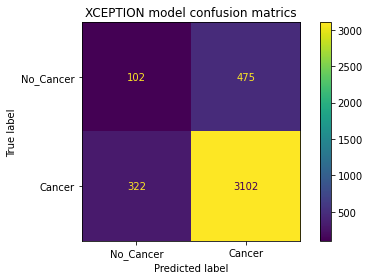

In [124]:
plot_confusion_matrix(val_df['cancer'], val_df['cancer_pred'].map(threshold), ['No_Cancer', 'Cancer'])

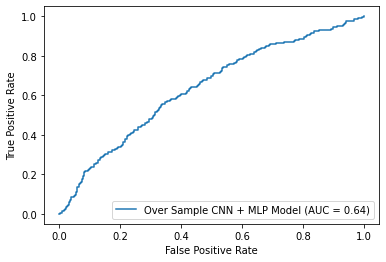

In [125]:
roc_curve_plot(val_df['cancer'], val_df['cancer_pred'], 'Over Sample CNN + MLP Model')

In [126]:
print_classification_report(
    val_df['cancer'], 
    val_df['cancer_pred'].round(), 
    [1, 0])

Classifier Report:
              precision    recall  f1-score   support

           1       0.86      1.00      0.92      3424
           0       0.00      0.00      0.00       577

    accuracy                           0.85      4001
   macro avg       0.43      0.50      0.46      4001
weighted avg       0.73      0.85      0.79      4001



----
Kaggle competition

In [78]:
kaggle_test = pd.read_csv(f'{base_path}/test.csv')

In [98]:
kaggle_test['laterality'] = kaggle_test['laterality'].map({'L': 0, 'R': 1})
kaggle_test['view'] = kaggle_test['view'].map({'CC': 0, 'MLO': 1})

In [80]:
kaggle_test['img_uri'] = ""

In [94]:
extract_patient_image_file_path(
    'test_breast_imaging_300px', kaggle_test, base_path, 
    'is_cancer', 'no_cancer', 'patient_id', 'image_id', 'img_uri', True)

/content/drive/MyDrive/General Assembly/breast_cancer_project/test_breast_imaging_300px/is_cancer/10008/is_cancer_10008_736471439.npz
/content/drive/MyDrive/General Assembly/breast_cancer_project/test_breast_imaging_300px/is_cancer/10008/is_cancer_10008_1591370361.npz
/content/drive/MyDrive/General Assembly/breast_cancer_project/test_breast_imaging_300px/is_cancer/10008/is_cancer_10008_68070693.npz
/content/drive/MyDrive/General Assembly/breast_cancer_project/test_breast_imaging_300px/is_cancer/10008/is_cancer_10008_361203119.npz


In [99]:
xception_model_density = load_model(f"{base_path}/models/Density Model/density_xception_model_v38.h5")

X_test = kaggle_test[['age', 'laterality', 'view']]
X_test_batched_image = construct_image_array(
    kaggle_test['img_uri'].tolist()
)
# Process prediction
density_predictions = xception_model_density.predict([X_test_batched_image, X_test]).flatten()

kaggle_test['density'] = density_predictions

1/1 [==============================] - 1s 893ms/step


In [100]:
# Cancer prediction
xception_model_cancer = load_model(f"{base_path}/models/Over Sampled Dataset/cancer_xception_model_v57.h5")

X_test = kaggle_test[['age', 'laterality', 'view', 'density']]

X_test_batched_image = construct_image_array(
    kaggle_test['img_uri'].tolist()
)

cancer_predictions = xception_model_cancer.predict([X_test_batched_image, X_test]).flatten()


1/1 [==============================] - 1s 844ms/step


In [101]:
kaggle_test['cancer'] = cancer_predictions
kaggle_test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,img_uri,density,cancer
0,2,10008,736471439,0,1,81,0,21,10008_L,/content/drive/MyDrive/General Assembly/breast...,0.999388,0.986979
1,2,10008,1591370361,0,0,81,0,21,10008_L,/content/drive/MyDrive/General Assembly/breast...,0.926073,0.986377
2,2,10008,68070693,1,1,81,0,21,10008_R,/content/drive/MyDrive/General Assembly/breast...,0.072295,0.987870
3,2,10008,361203119,1,0,81,0,21,10008_R,/content/drive/MyDrive/General Assembly/breast...,0.138119,0.987285


In [103]:
kaggle_test[['prediction_id', 'cancer']].to_csv(f"{base_path}/kaggle_submission.csv", index=False)